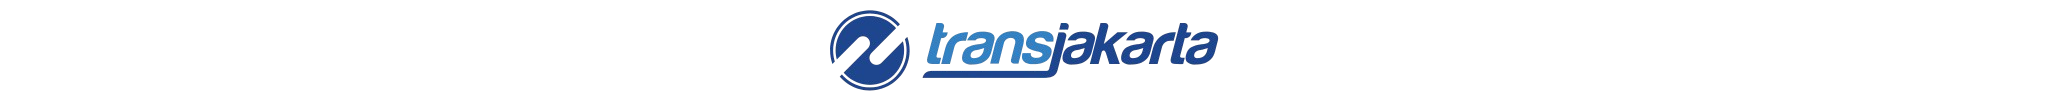

<h1 style='text-align:center; color:'#007BFF'><b>Evaluasi Keoptimalan Penempatan Armada Bus Pink di TransJakarta</b></h1>
<h5 style="text-align: center;"> Muhammad Hafizh Bayhaqi [JCDS-2704]</h2>

# **Data**
Untuk menjawab pertanyaan di atas, saya akan menganalisis data transaksi Transjakarta yang sudah dikumpulkan oleh perusahaan. Dataset dapat di akses [di sini](https://drive.google.com/drive/folders/1S04hk5uHfHYe6J1S6fVqDunuja1Lk1Lo)

____

## Library & Helper Functions

### Library Imports

Untuk analisis data dan visualisasi, kita menggunakan beberapa pustaka Python utama:

- **`pandas`**: Digunakan untuk manipulasi dan analisis data, terutama dalam bentuk DataFrame.
- **`numpy`**: Menyediakan dukungan untuk operasi matematis dan array multidimensi.
- **`matplotlib`**: Pustaka utama untuk visualisasi data, memungkinkan pembuatan grafik dan plot.
- **`seaborn`**: Dibangun di atas matplotlib, menyediakan antarmuka tingkat tinggi untuk membuat visualisasi statistik yang menarik dan informatif.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import statsmodels.api as sm
import folium
from scipy.stats import normaltest

import warnings
warnings.filterwarnings("ignore")

### Helper Functions

Fungsi-fungsi berikut membantu dalam analisis dan visualisasi data:

- **`print_data_info(df)`**: 
  Menampilkan informasi rinci tentang DataFrame yang diberikan, termasuk tipe data setiap kolom, jumlah dan persentase nilai yang hilang, serta jumlah nilai unik. Ini berguna untuk memahami struktur dan kualitas data sebelum analisis lebih lanjut.

- **`draw_isna_heatmap(df, title='')`**:
  Menggambar heatmap yang menunjukkan lokasi nilai yang hilang (null) dalam DataFrame. Menggunakan kolormap 'inferno', fungsi ini membantu visualisasi penyebaran nilai yang hilang di seluruh DataFrame.

- **`draw_isna_heatmap_side_by_side(df_list, titles)`**:
  Menggambar dua heatmap berdampingan untuk membandingkan lokasi nilai yang hilang antara dua DataFrame. Heatmap ditampilkan dalam format berdampingan untuk memudahkan perbandingan visual antara dua DataFrame yang berbeda, dengan masing-masing diberi judul sesuai dengan daftar `titles`.

In [2]:
def print_data_info(df):
    """
    Menampilkan informasi rinci tentang DataFrame, termasuk detail tipe data,
    jumlah dan persentase nilai yang hilang, serta jumlah nilai unik untuk setiap kolom.

    Informasi yang ditampilkan meliputi:
    - Tipe data untuk setiap kolom.
    - Jumlah nilai yang hilang (null) di setiap kolom.
    - Persentase nilai yang hilang dari total jumlah nilai di setiap kolom.
    - Jumlah nilai unik di setiap kolom.
    - Sample dari setiap kolom.
    
    Args:
        df (pd.DataFrame): DataFrame yang akan dianalisis. Harus merupakan objek DataFrame dari pustaka pandas.

    Returns:
        None: Fungsi ini hanya menampilkan informasi dan tidak mengembalikan nilai.
    """
    # Buat DataFrame untuk menyimpan informasi kolom
    data_info = pd.DataFrame({
        'Feature': df.columns,
        'Data Type': df.dtypes,
        'Null Count': df.isna().sum(),
        'Null Percentage (%)': (df.isna().mean() * 100).round(2),
    })
    data_info.reset_index(drop=True, inplace=True)
    
    # Tampilkan Informasi
    print(f'Jumlah baris: {df.shape[0]:,}, Jumlah kolom: {df.shape[1]:,}')
    print('-' * 80)
    display(data_info)


In [3]:
def draw_isna_heatmap(df, title=''):
    """
    Menggambar heatmap untuk menampilkan lokasi nilai yang hilang (null) dalam DataFrame.

    Heatmap ini menggunakan kolormap 'inferno' untuk menunjukkan sel-sel dengan nilai yang hilang. 
    Sel-sel dengan nilai yang hilang akan ditandai dengan warna yang berbeda, sedangkan sel-sel yang memiliki nilai tidak akan berwarna.

    Args:
        df (pd.DataFrame): DataFrame yang akan dianalisis. Harus merupakan objek DataFrame dari pustaka pandas.
        title (str, optional): Judul untuk heatmap yang ditampilkan. Default adalah string kosong.

    Returns:
        None: Fungsi ini hanya menampilkan heatmap dan tidak mengembalikan nilai.
    """
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isna(), cmap='inferno', cbar=False, yticklabels=False)
    plt.title(title)
    plt.xlabel('Kolom')
    plt.ylabel('Baris')
    plt.show()
    
    
def draw_isna_heatmap_side_by_side(df_list, titles):
    """
    Menggambar dua heatmap berdampingan untuk membandingkan lokasi nilai yang hilang (null) antara dua DataFrame.

    Heatmap ini menggunakan kolormap 'inferno' untuk menunjukkan sel-sel dengan nilai yang hilang. 
    Sel-sel dengan nilai yang hilang akan ditandai dengan warna yang berbeda, sedangkan sel-sel yang memiliki nilai tidak akan berwarna. 
    Heatmap ditampilkan dalam format berdampingan untuk memudahkan perbandingan visual antara dua DataFrame.

    Args:
        df_list (list of pd.DataFrame): Daftar yang berisi dua DataFrame yang akan dianalisis. Setiap elemen dalam daftar harus merupakan objek DataFrame dari pustaka pandas.
        titles (list of str): Daftar yang berisi dua string yang digunakan sebagai judul untuk setiap heatmap. Panjang daftar harus sesuai dengan jumlah DataFrame dalam df_list.

    Returns:
        None: Fungsi ini hanya menampilkan heatmap dan tidak mengembalikan nilai.
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    for dataframe, title, axis in zip(df_list, titles, ax):
        sns.heatmap(dataframe.isna(), cmap='inferno', cbar=False, yticklabels=False, ax=axis)
        axis.set_title(title)
        axis.set_xlabel('Kolom')
        axis.set_ylabel('Baris')
    plt.tight_layout()
    plt.show()


## Data Description

| Nama Kolom        | Deskripsi                                                       |
|-------------------|------------------------------------------------------------------|
| `TransID`           | ID transaksi unik untuk setiap transaksi                        |
| `PayCardID`         | Identifikasi utama pelanggan. Kartu yang digunakan pelanggan sebagai tiket untuk masuk dan keluar |
| `PayCardBank`       | Nama bank penerbit kartu pelanggan                               |
| `PayCardName`       | Nama pelanggan yang tertera pada kartu                           |
| `PayCardSex`        | Jenis kelamin pelanggan yang tertera pada kartu                  |
| `PayCardBirthDate`  | Tahun kelahiran pelanggan                                        |
| `CorridorID`        | ID koridor / ID rute yang digunakan sebagai kunci untuk pengelompokan rute |
| `CorridorName`      | Nama koridor / Nama rute yang mencakup titik awal dan akhir dari setiap rute |
| `Direction`         | 0 untuk Pergi, 1 untuk Kembali. Arah rute                       |
| `TapInStops`        | ID halte tap-in (masuk) untuk mengidentifikasi nama halte       |
| `TapInStopsName`    | Nama halte tap-in (masuk) tempat pelanggan melakukan tap-in      |
| `TapInStopsLat`     | Lintang dari halte tap-in (masuk)                               |
| `TapInStopsLon`     | Bujur dari halte tap-in (masuk)                                 |
| `StopStartSeq`      | Urutan halte, halte pertama, kedua, dan seterusnya. Terkait dengan arah |
| `TapInTime`         | Waktu saat tap-in. Tanggal dan waktu                             |
| `TapOutStops`       | ID halte tap-out (keluar) untuk mengidentifikasi nama halte     |
| `TapOutStopsName`   | Nama halte tap-out (keluar) tempat pelanggan melakukan tap-out  |
| `TapOutStopsLat`    | Lintang dari halte tap-out (keluar)                              |
| `TapOutStopsLon`    | Bujur dari halte tap-out (keluar)                                |
| `StopEndSeq`        | Urutan halte, halte pertama, kedua, dan seterusnya. Terkait dengan arah |
| `TapOutTime`        | Waktu saat tap-out. Tanggal dan waktu                            |
| `PayAmount`         | Jumlah yang dibayar pelanggan. Beberapa gratis, beberapa tidak  |


In [4]:
df = pd.read_csv('Transjakarta.csv')
df.head(10)

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,...,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,...,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via Patra Kuningan,0.0,B01963P,...,106.83302,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6.217152,106.81892,21.0,2023-04-03 06:40:01,3500.0
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0.0,B00499P,...,106.81435,38,2023-04-03 05:59:06,B04962P,Simpang Kunir Kemukus,-6.133731,106.81475,39.0,2023-04-03 06:50:55,3500.0
3,JTUZ800U7C86EH,639099174703,flazz,Surya Wacana,F,1978,11D,Pulo Gebang - Pulo Gadung 2 via PIK,0.0,B05587P,...,106.93526,23,2023-04-03 05:44:51,B03090P,Raya Penggilingan,-6.183068,106.93194,29.0,2023-04-03 06:28:16,3500.0
4,VMLO535V7F95NJ,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,0.0,P00239,...,106.88900,5,2023-04-03 06:17:35,P00098,Kali Besar Barat,-6.135355,106.81143,15.0,2023-04-03 06:57:03,3500.0
5,DDES630K2F80KC,2251412124634980,dki,Tirta Siregar,F,1993,1T,Cibubur - Balai Kota,0.0,B00127P,...,106.81632,3,2023-04-03 05:08:01,B00694P,Grand Sahid,-6.210975,106.82059,6.0,2023-04-03 05:52:25,20000.0
6,HEMW326B9N91TV,213155822653833,emoney,"R. Devi Hariyah, S.T.",M,1974,JAK.18,Kalibata - Kuningan,0.0,B00243P,...,106.85165,25,2023-04-03 06:58:21,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,XTKE052E5E87LN,3587341902618993,dki,Darmanto Rajasa,F,1991,NaN,NaN,1.0,B03416P,...,106.80221,2,2023-04-03 06:44:24,B00899P,Jln. Baros,-6.311046,106.78400,12.0,2023-04-03 07:11:43,0.0
8,OIHS248V7S72EB,6510013988638519,dki,"Cagak Maheswara, S.Sos",F,1992,B14,Bekasi Barat - Kuningan,1.0,B00795P,...,106.83059,1,2023-04-03 06:01:44,B01853P,Kayuringin 2,-6.245948,106.99247,16.0,2023-04-03 06:51:12,20000.0
9,ERXO372B2H63RB,3580401035990896,dki,"T. Dadap Pradana, M.Ak",M,2004,1Q,Rempoa - Blok M,0.0,B05781P,...,106.77889,15,2023-04-03 05:57:47,B06578P,Blok M Jalur 3,-6.243426,106.80188,24.0,2023-04-03 06:51:12,3500.0


## Data Understanding

Sebelum memulai analisis, kita perlu mengetahui dataset kita lebih baik pada fase understanding data. Dari proses ini, kita akan mengetahui anomali apa saja yang ada pada kumpulan data kita yang perlu diatasi pada fase cleaning data. Setiap  anomali yang ditangani akan disertai dengan penjelasan langkah-langkah yang dilakukan, baik dari segi domain knowledge maupun secara statistik.

Pertama, mari kita lihat informasi pada dataset Transjakarta.

### Sekilas Tentang Data

In [5]:
print_data_info(df)

Jumlah baris: 37,900, Jumlah kolom: 22
--------------------------------------------------------------------------------


,Feature,Data Type,Null Count,Null Percentage (%)
0,transID,object,0,0.00
1,payCardID,int64,0,0.00
2,payCardBank,object,0,0.00
3,payCardName,object,0,0.00
4,payCardSex,object,0,0.00
5,payCardBirthDate,int64,0,0.00
6,corridorID,object,1257,3.32
7,corridorName,object,1930,5.09
8,direction,float64,0,0.00
9,tapInStops,object,1213,3.20


In [6]:
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,transID,37900,"[EIIW227B8L34VB, LGXO740D2N47GZ, DJWR385V2U57T..."
1,payCardID,2000,"[180062659848800, 4885331907664776, 4996225095..."
2,payCardBank,6,"[emoney, dki, flazz, online, brizzi, bni]"
3,payCardName,1993,"[Bajragin Usada, Gandi Widodo, Emong Wastuti, ..."
4,payCardSex,2,"[M, F]"
5,payCardBirthDate,67,"[2008, 1997, 1992, 1978, 1982, 1993, 1974, 199..."
6,corridorID,221,"[5, 6C, R1A, 11D, 12, 1T, JAK.18, nan, B14, 1Q..."
7,corridorName,216,"[Matraman Baru - Ancol, Stasiun Tebet - Karet ..."
8,direction,2,"[1.0, 0.0]"
9,tapInStops,2570,"[P00142, B01963P, B00499P, B05587P, P00239, B0..."


---
**📝 Gambaran Umum**

- **🔢 Dataset:**
  - Dataset Transjakarta memiliki 22 kolom dan 37.900 baris
  - Kolom yang memiliki missing value : `corridorID`, `corridorName`, `tapInStops`, `tapOutStops`, `tapOutStopsName`, `tapOutStopsLat`, `tapOutStopsLon`, `stopEndSeq`, `tapOutTime`, `payAmount` (10 kolom)
  
- **📊 Kolom:**
  - `payCardID` berisikan id unik untuk setiap pelanggan, kolom tersebut memiliki data tipe int64. Dari penjelasannya, kolom ini seharusnya berisikan data object.
  - `tapInTime` dan `tapOutTime` memiliki data tipe object. Dari penjelasannya, kolom ini seharusnya berisikan data datetime. Mari kita cek lebih detil.
  - `direction` memiliki value data 0 dan 1. Dari penjelasannya sebagai arah rute, value data dapat diubah yaitu 0 untuk Berangkat, 1 untuk Pulang.
  - `transID` berisikan id unik untuk setiap transaksi dari pelanggan, sehingga tidak relevan dalam analisis dan bisa dihapus saja.
---


In [7]:
df.drop('transID', axis=1, inplace=True)
df["payCardID"] = df["payCardID"].astype(str)
df["direction"] = df["direction"].replace({0: "Keberangkatan", 1: "Pulang"})
df['tapInTime'] = pd.to_datetime(df['tapInTime'])
df['tapOutTime'] = pd.to_datetime(df['tapOutTime'])

In [8]:
print_data_info(df)

Jumlah baris: 37,900, Jumlah kolom: 21
--------------------------------------------------------------------------------


,Feature,Data Type,Null Count,Null Percentage (%)
0,payCardID,object,0,0.00
1,payCardBank,object,0,0.00
2,payCardName,object,0,0.00
3,payCardSex,object,0,0.00
4,payCardBirthDate,int64,0,0.00
5,corridorID,object,1257,3.32
6,corridorName,object,1930,5.09
7,direction,object,0,0.00
8,tapInStops,object,1213,3.20
9,tapInStopsName,object,0,0.00


Dari perubahan diatas, kita sudah merubah beberapa kolom dari dataset Transjakarrta:
1. kolom `transID` dihapus karena merupakan id unik dari transaksi pengguna, jadi tidak relevan dalam analisis.
2. kolom `payCardID` sudah diganti datatypenya dengan object dengan tujuan agar sesuai dengan karakteristik dari datanya, yaitu kategorik.
3. kolom `direction` sudah diganti value datanya menjadi keberangkatan dan pulang. hal tersebut untuk menjelaskan arah keberangkatan dari rute.
4. kolom `tapInTime` sudah diganti datatypenya dengan datetime dengan tujuan agar sesuai dengan karakteristik dari datanya, yaitu kombinasi tanggal dan waktu.
5. kolom `tapOutTime` sudah diganti datatypenya dengan datetime dengan tujuan agar sesuai dengan karakteristik dari datanya, yaitu kombinasi tanggal dan waktu.

---

### Cek Missing Value

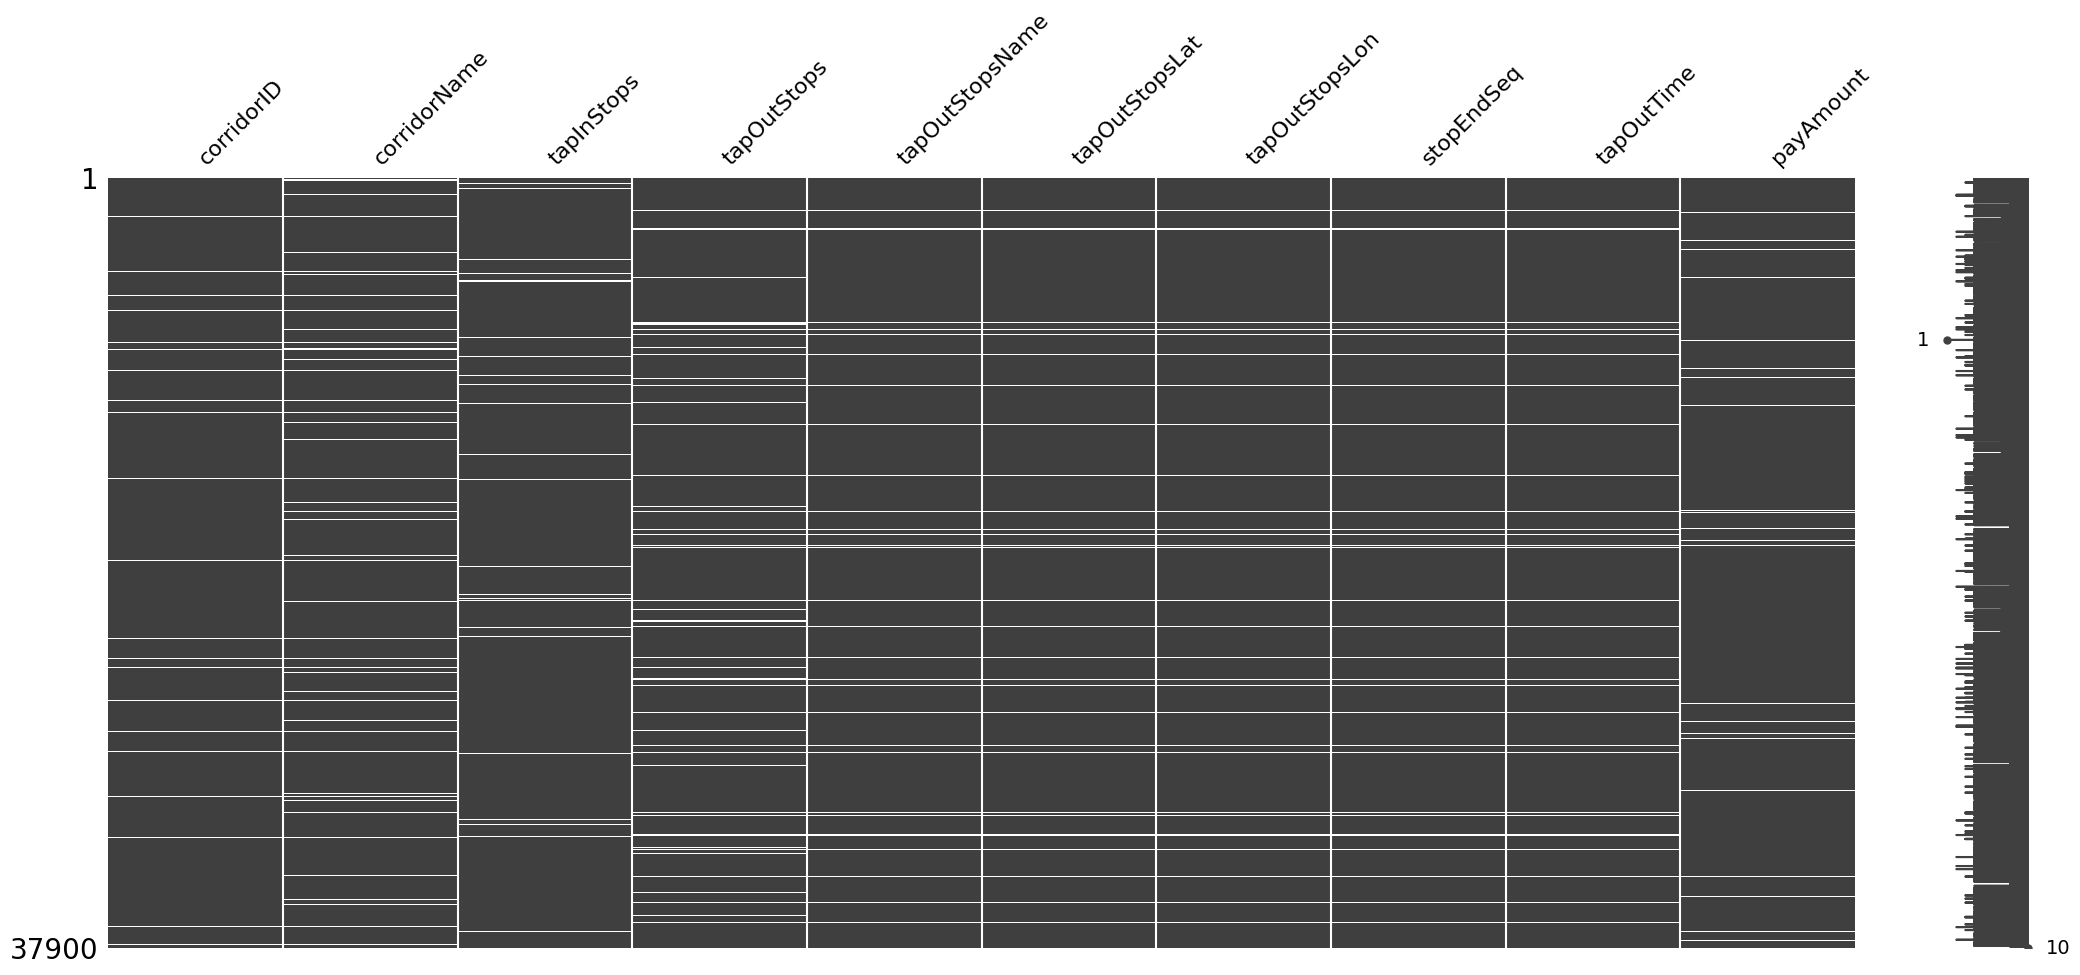

In [9]:
missingno.matrix(df[['corridorID', 'corridorName', 'tapInStops', 'tapOutStops', 'tapOutStopsName', 'tapOutStopsLat', 'tapOutStopsLon',
'stopEndSeq', 'tapOutTime', 'payAmount']])

plt.show()

In [10]:
df[df.isna().any(axis = 1)]

,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,...,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,213155822653833,emoney,"R. Devi Hariyah, S.T.",M,1974,JAK.18,Kalibata - Kuningan,Keberangkatan,B00243P,Cervino Village,...,106.85165,25,2023-04-03 06:58:21,NaN,NaN,NaN,NaN,NaN,NaT,0.0
7,3587341902618993,dki,Darmanto Rajasa,F,1991,NaN,NaN,Pulang,B03416P,SDN Pondok Labu 11,...,106.80221,2,2023-04-03 06:44:24,B00899P,Jln. Baros,-6.311046,106.78400,12.0,2023-04-03 07:11:43,0.0
11,347204308990092,emoney,R.M. Labuh Laksmiwati,F,1984,M7B,BKN - Blok M,Pulang,P00254,Tendean,...,106.83102,12,2023-04-03 06:22:10,P00129,Mampang Prapatan,-6.242699,106.82572,14.0,2023-04-03 06:50:21,NaN
21,343851798729291,emoney,Garang Utama,F,1997,JAK.16,Cililitan - Condet,Keberangkatan,NaN,Lippo Mall Kramat Jati,...,106.86741,4,2023-04-03 05:08:36,B01393P,Jln. Mesjid Al Mabruk,-6.284350,106.85293,20.0,2023-04-03 05:30:45,0.0
30,3589380857722689,dki,drg. Lukman Hidayanto,M,1995,JAK.46,Pasar Minggu - Jagakarsa,Pulang,B00001P,18 Office Park,...,106.83210,19,2023-04-03 06:14:02,NaN,NaN,NaN,NaN,NaN,NaT,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37878,36067042340502,bni,Jatmiko Mansur,F,1965,D32,Cinere - Bundaran Senayan,Keberangkatan,B06642P,Mega Cinere,...,106.78282,4,2023-04-16 07:59:08,NaN,FX Sudirman,-6.225532,106.80370,7.0,2023-04-16 10:58:11,20000.0
37882,180074952289665,emoney,Asmadi Setiawan,F,1971,JAK.48B,Stasiun Tebet - Kampung Melayu,Keberangkatan,B01732P,Jatinegara Timur,...,106.86825,11,2023-04-30 08:41:09,B01169P,Jln. Jatinegara Timur IV,-6.222457,106.86816,13.0,2023-04-30 10:07:19,NaN
37885,30169751274025,bni,Prasetya Wasita,M,1986,3B,NaN,Pulang,B04610P,Sekolah Al Huda 1,...,106.72736,2,2023-04-08 10:46:06,B00192P,BSI Cengkareng,-6.147973,106.72781,3.0,2023-04-08 13:06:42,0.0
37887,4068989702474318,dki,Ajimat Pradana,F,1980,4D,Pulo Gadung 2 - Kuningan,Keberangkatan,P00269,Velodrome,...,106.88830,5,2023-04-04 14:52:31,NaN,Pramuka LIA,-6.192238,106.86858,9.0,2023-04-04 15:38:58,3500.0


Secara garis besar:  
* *missing value* di kolom `corridorID`, `corridorName`, `tapInStops`, `tapOutStops`, `tapOutStopsName`, `tapOutStopsLat`, `tapOutStopsLon`, `stopEndSeq`, `tapOutTime` dan `payAmount` memiliki jumlah yang banyak dan proporsi sedikit, dengan missing value di kolom `tapOutStops` mencapai 6.03%.
* *missing value* di kolom `corridorID` dan `corridorName` memiliki sebaran yang terlihat berkaitan, jika data di `corridorID` kosong, maka kemungkinan besar data di `corridorName` juga kosong. 
* *missing value* di kolom `tapOutStops`, `tapOutStopsName`, `tapOutStopsLat`, `tapOutStopsLon`, `stopEndSeq`, dan `tapOutTime` memiliki sebaran yang terlihat berkaitan, jika data di `tapOutStops` kosong, maka kemungkinan besar data di `company_type` juga kosong.  
* ada beberapa *missing value* di kolom `corridorName`, `tapInStops` dan `tapOutStops` memiliki sebaran yang berdiri sendiri.
* *missing value* di kolom `payAmount` memiliki sebaran yang berdiri sendiri.

Cara untuk menangani *missing value* adalah kita dapat menggunakan strategi mengisi data yang hilang berdasarkan kolom lain yang memiliki keterkaitan atau dengan nilai sebenarnya sesuai domain knowledge. Penghapusan data sebaiknya dihindari, terutama karena jumlah missing value yang signifikan dalam beberapa kolom. Pengisian missing value harus dilakukan dengan hati-hati dan berdasarkan domain knowledge atau analisis statistik. Pengisian dengan nilai rata-rata (mean), median, atau modus akan menjadi opsi terakhir jika tidak ada informasi yang lebih baik untuk mengisi missing value.

### Numerik

In [11]:
numerik = df.select_dtypes(include= 'number')
numerik

,payCardBirthDate,tapInStopsLat,tapInStopsLon,stopStartSeq,tapOutStopsLat,tapOutStopsLon,stopEndSeq,payAmount
0,2008,-6.184631,106.84402,7,-6.203101,106.85715,12.0,3500.0
1,1997,-6.228700,106.83302,13,-6.217152,106.81892,21.0,3500.0
2,1992,-6.133132,106.81435,38,-6.133731,106.81475,39.0,3500.0
3,1978,-6.195743,106.93526,23,-6.183068,106.93194,29.0,3500.0
4,1982,-6.149650,106.88900,5,-6.135355,106.81143,15.0,3500.0
...,...,...,...,...,...,...,...,...
37895,2004,-6.196892,106.82309,2,-6.290967,106.82365,13.0,3500.0
37896,1974,-6.290154,106.88116,1,-6.291075,106.88634,2.0,3500.0
37897,1976,-6.216247,106.81676,12,-6.370321,106.89628,14.0,20000.0
37898,1976,-6.188656,106.80954,33,-6.188861,106.81135,34.0,0.0


In [12]:
numerik.describe()

,payCardBirthDate,tapInStopsLat,tapInStopsLon,stopStartSeq,tapOutStopsLat,tapOutStopsLon,stopEndSeq,payAmount
count,37900.000000,37900.000000,37900.000000,37900.000000,36556.000000,36556.000000,36556.000000,36893.000000
mean,1990.089314,-6.214838,106.841554,13.572480,-6.214651,106.841233,21.219909,2699.712683
std,13.051482,0.057911,0.060369,12.237623,0.059022,0.060999,13.800689,4212.225592
min,1946.000000,-6.394973,106.614730,0.000000,-6.394973,106.614730,1.000000,0.000000
25%,1982.000000,-6.245863,106.803470,4.000000,-6.247225,106.801750,11.000000,0.000000
50%,1990.000000,-6.214587,106.834830,10.000000,-6.214718,106.834580,18.000000,3500.000000
75%,2001.000000,-6.175528,106.882270,19.000000,-6.174736,106.883030,29.000000,3500.000000
max,2012.000000,-6.089429,107.023950,68.000000,-6.091746,107.023660,77.000000,20000.000000


secara keseluruhan dapat kita lihat bahwa
1. Rata-rata tahun kelahiran penumpang adalah sekitar 1990.08, dengan tahun kelahiran minimum pada tahun 1946 dan maksimum pada tahun 2012.
2. Urutan berhenti (stop sequence) memiliki nilai rata-rata sekitar 13.57 untuk `stopStartSeq` dan sekitar 21.22 untuk `stopEndSeq`.
3. nilai median dan nilai mean nya hampir sama.
4. Jumlah pembayaran memiliki standar deviasi yang tinggi, yaitu sekitar 4212.22, menunjukkan variasi yang besar dalam jumlah pembayaran.

### Uji Normalitas

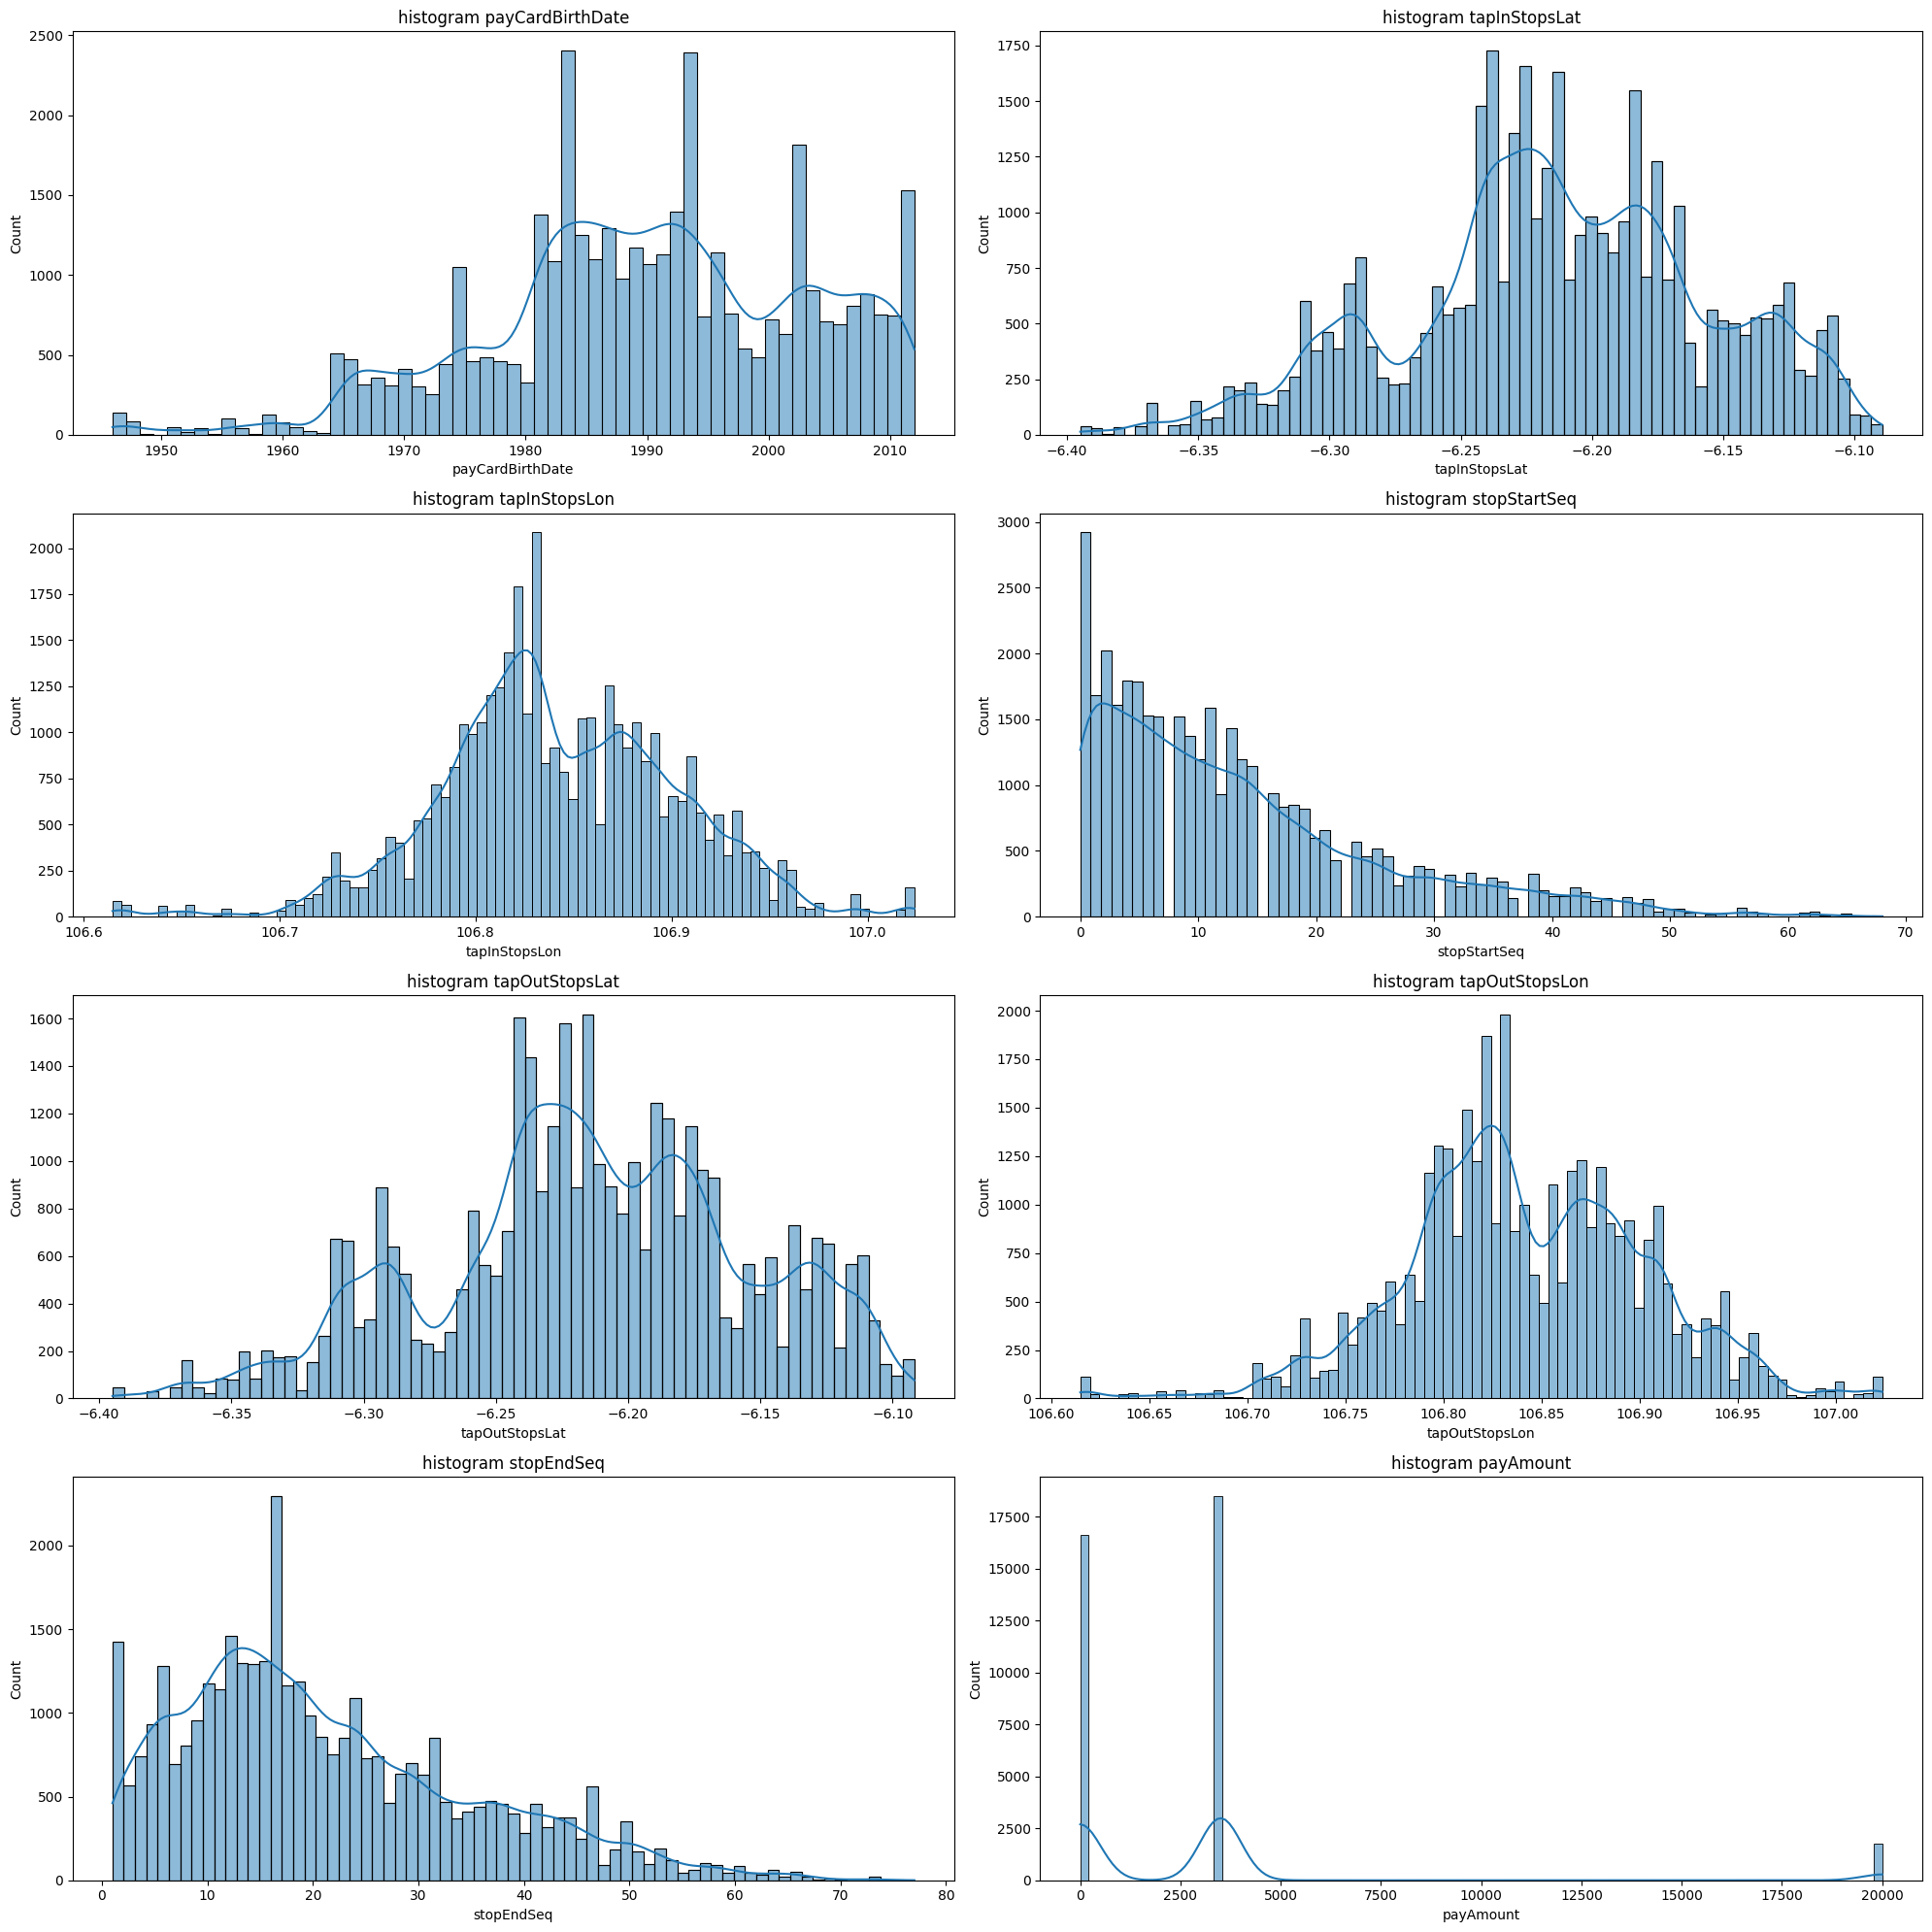

In [13]:
fig = plt.figure(figsize=(20,20)) # horizontal, vertikal

count = 0
for kolom in numerik.columns:
    count += 1
    plt.subplot(4,2,count)
    sns.histplot(numerik[kolom], kde=True)
    plt.title(f"histogram {kolom}")
    fig.tight_layout() # biar tidak tertumpuk
plt.show()

berdasarkan dari histogram diatas dapat disimpulkan bahwa
- `payCardBirthDate` memiliki bentuk distribusi yang miring ke kanan, hal ini menunjukkan bahwa data tersebut didistribusikan secara right skewed.
- `tapinStopsLon`, dan `tapOutStopsLon` memiliki bentuk distribusi yang normal
- `tapinStopsLat`, `stopStartSeq` dan `tapOutStopsLat` memiliki bentuk distribusi  secara uniform.
- `stopEndSeq` dan `payAmount` memiliki bentuk distribusi yang miring ke kanan, hal ini menunjukkan bahwa data tersebut didistribusikan secara right skewed.

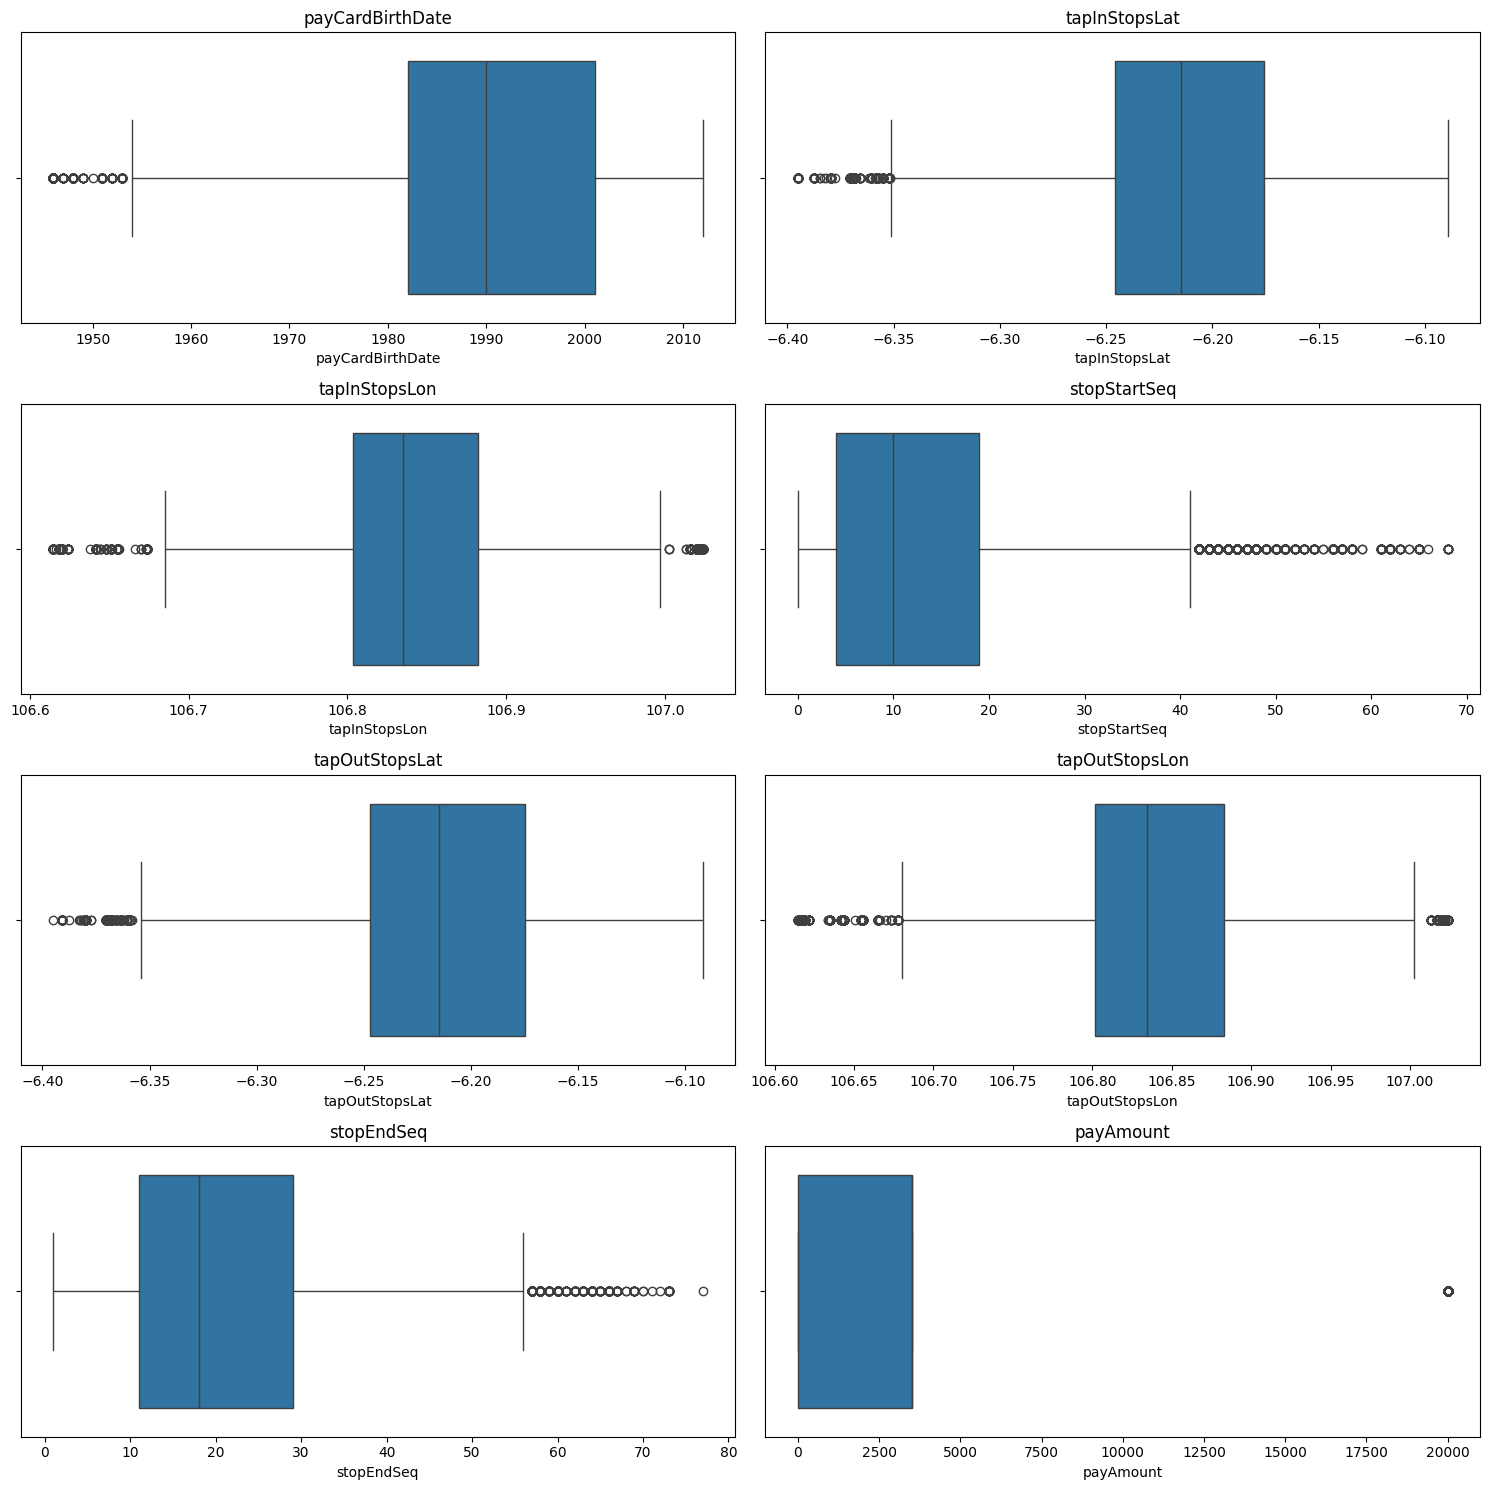

In [14]:
fig = plt.figure(figsize=(15,15)) # horizontal, vertikal

count = 0
for kolom in numerik.columns:
    count += 1
    plt.subplot(4,2,count)
    sns.boxplot(numerik, x = kolom)
    fig.tight_layout() # biar tidak tertumpuk
    plt.title(f'{kolom}')
plt.show()

In [15]:
outliers_count = []

for column in numerik.columns:
    z_scores = np.abs((numerik[column] - numerik[column].mean()) / numerik[column].std()) # tidak cocok dengan data tidak terdistribusi normal
    count = len(z_scores[z_scores > 2])  # umumnya 2, tapi juga bisa disesuaikan dengan melihat bagaimana data mulai meruncing atau ekstrim
    outliers_count.append({'Column': column, 'Outliers Count': count})

outliers_df = pd.DataFrame(outliers_count)

print("DataFrame jumlah outliers tiap kolom:")
outliers_df

DataFrame jumlah outliers tiap kolom:


,Column,Outliers Count
0,payCardBirthDate,782
1,tapInStopsLat,1390
2,tapInStopsLon,1387
3,stopStartSeq,2055
4,tapOutStopsLat,1241
5,tapOutStopsLon,1438
6,stopEndSeq,1800
7,payAmount,1742


- Berdasarkan perhitungan menggunakan Quantile on Quantile Regression dan Z Score menunjukan adanya perbedaan jumlah outliers yang cukup signifikan.
- hanya kolom `payAmount` yang tidak memiliki perbedaan jumlah outliersnya 

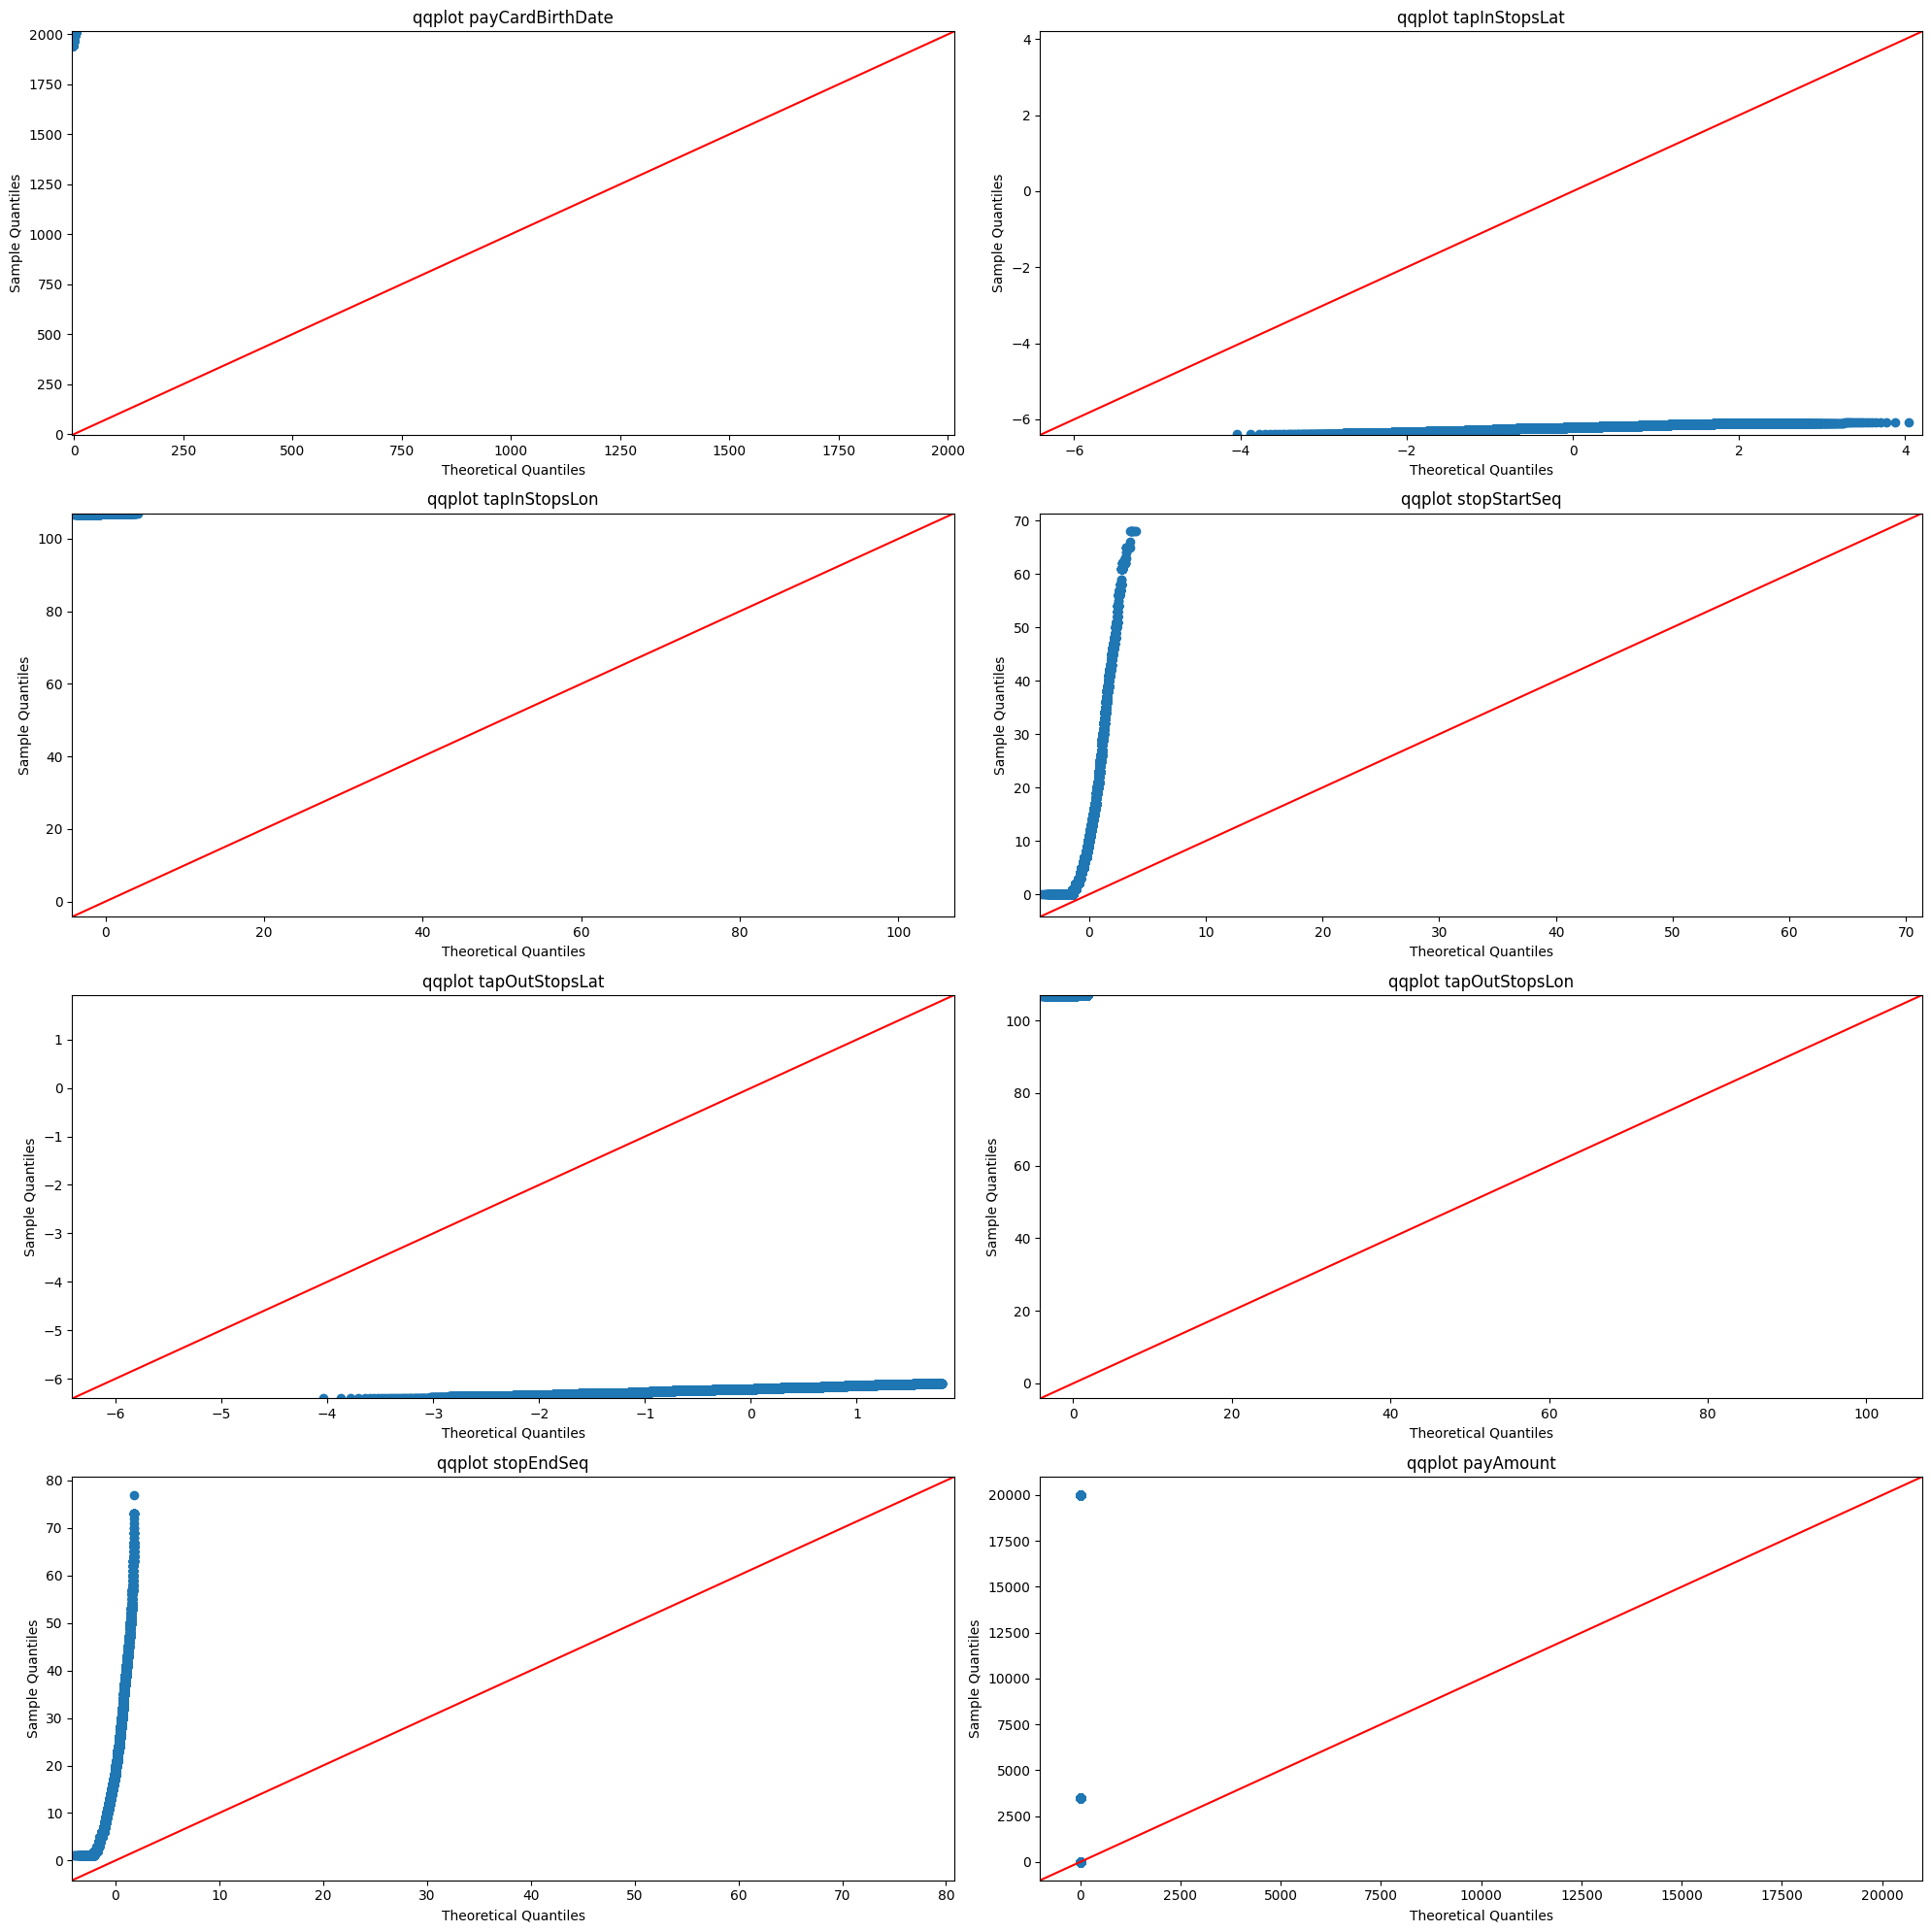

In [16]:
fig = plt.figure(figsize=(20,20)) # horizontal, vertikal

count = 0
for kolom in numerik.columns:
    count += 1
    ax = plt.subplot(4,2,count)
    sm.qqplot(numerik[kolom], line='45', ax = ax)
    plt.title(f"qqplot {kolom}")
    fig.tight_layout() # biar tidak tertumpuk

plt.show()

Dari gambar diatas dapat disimpulkan bahwa semua data yang divisualisasikan menggunakan qqplot tidak memiliki pattern yang normal

### Dengan Statistika

In [134]:
for col in numerik.columns:
    stat, p_value = normaltest(df[col])
    print(f"Kolom '{col}':")
    print("p-value =", p_value)
    
    # Interpretasi hasil tes
    alpha = 0.05
    if p_value > alpha:
         print("Data terdistribusi normal (tidak dapat menolak H0)")
    else:
         print("Data tidak terdistribusi normal (menolak H0)")
    print()

Kolom 'payCardBirthDate':
p-value = 6.566679395848745e-218
Data tidak terdistribusi normal (menolak H0)

Kolom 'tapInStopsLat':
p-value = 4.936624951306019e-112
Data tidak terdistribusi normal (menolak H0)

Kolom 'tapInStopsLon':
p-value = 3.373017404311752e-91
Data tidak terdistribusi normal (menolak H0)

Kolom 'stopStartSeq':
p-value = 0.0
Data tidak terdistribusi normal (menolak H0)

Kolom 'tapOutStopsLat':
p-value = nan
Data tidak terdistribusi normal (menolak H0)

Kolom 'tapOutStopsLon':
p-value = nan
Data tidak terdistribusi normal (menolak H0)

Kolom 'stopEndSeq':
p-value = nan
Data tidak terdistribusi normal (menolak H0)

Kolom 'payAmount':
p-value = nan
Data tidak terdistribusi normal (menolak H0)



Kesimpulan :

- Dari uji normalitas diatas menggunakan histgram dapat dilihat bahwasannya data tidak ada yang normal setap data numerik memiliki pola tertentu
    - Right Skeewed : StopSTarSeq, payAmount, danStopEndSeq
    - Left Skeewed : PayCardBirthDate, tapinStopLat, tapinStopLon, tapOutStopLat, tapInstopLat
- Dari Uji statistik nmenggunakan uji normalitas juga dibuktikan menggunakan alpha = 0.05 setiap data numerik juga tidak terdisribusi normal setiap pvalue > 0.05

### Korelasi

In [18]:
numeric_columns = df.select_dtypes(include=[np.number])
df_corr = numeric_columns.corr(method="spearman")
df_corr

,payCardBirthDate,tapInStopsLat,tapInStopsLon,stopStartSeq,tapOutStopsLat,tapOutStopsLon,stopEndSeq,payAmount
payCardBirthDate,1.000000,0.053390,-0.052694,-0.024925,0.033952,-0.044056,-0.023479,0.074565
tapInStopsLat,0.053390,1.000000,0.023666,-0.007995,0.910567,0.032871,-0.020717,-0.130678
tapInStopsLon,-0.052694,0.023666,1.000000,0.052814,0.032628,0.914414,0.089086,-0.295555
stopStartSeq,-0.024925,-0.007995,0.052814,1.000000,-0.024018,0.045309,0.791717,-0.264551
tapOutStopsLat,0.033952,0.910567,0.032628,-0.024018,1.000000,0.013989,-0.027788,-0.129890
tapOutStopsLon,-0.044056,0.032871,0.914414,0.045309,0.013989,1.000000,0.081366,-0.286594
stopEndSeq,-0.023479,-0.020717,0.089086,0.791717,-0.027788,0.081366,1.000000,-0.386481
payAmount,0.074565,-0.130678,-0.295555,-0.264551,-0.129890,-0.286594,-0.386481,1.000000


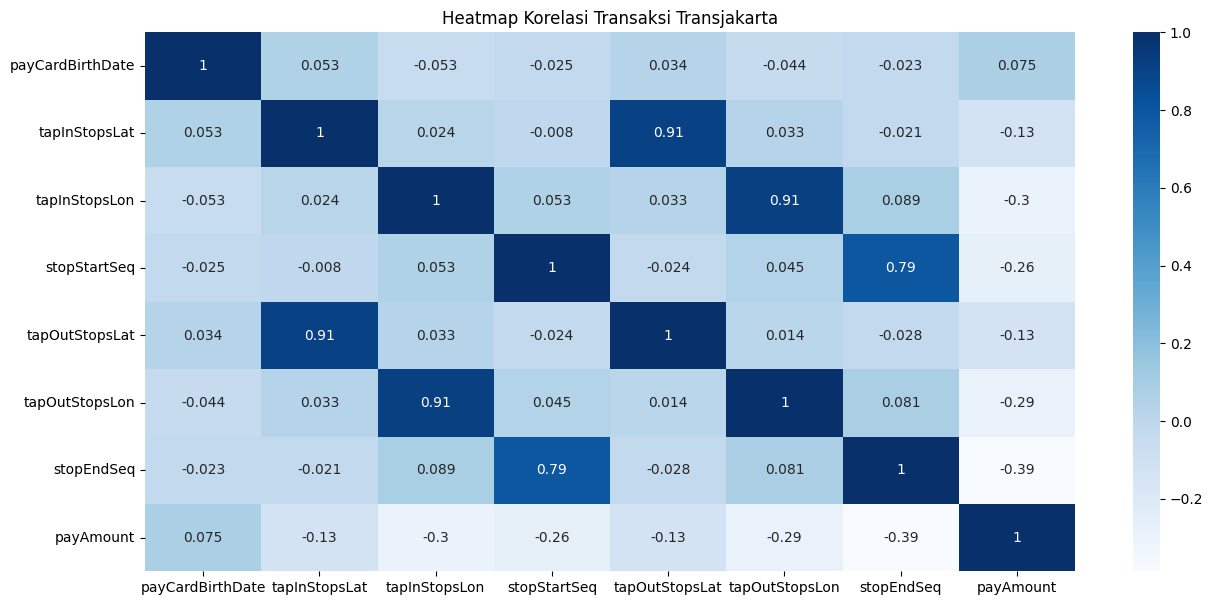

In [19]:
plt.figure(figsize = (15,7))
sns.heatmap(data=df_corr, annot=True, cmap='Blues')
plt.title("Heatmap Korelasi Transaksi Transjakarta")
plt.show()

Kesimpulan :
- Berdasarkan uji korelasi menggunakan Heatmap dapat dilihat beberapa kolom yang memiliki hubungan korelasi yang kuat
    - kolom tapInstopLat dan tapInStopLon memeiliki hubungan korelasi yang sangat kuat positif taitu sebesar 0.91
    - kolom tapInStopLon dan tapOutStopLon memiliki hubungan korelasi yang sangta kuat positif yaitu sebesar 0.91
    - kolomStopStarseq dan stopEndseq memiliki hubungan yang sangat kuat positif yaitu sebesar 0.79
    

### Kategorik

In [20]:
kategorik = df.select_dtypes(exclude="number")
kategorik.describe(include='object')

,payCardID,payCardBank,payCardName,payCardSex,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapOutStops,tapOutStopsName
count,37900,37900,37900,37900,36643,35970,37900,36687,37900,35611,36556
unique,2000,6,1993,2,221,216,2,2570,2602,2230,2248
top,6011319634394124,dki,Suci Wacana,F,1T,Cibubur - Balai Kota,Pulang,P00170,Penjaringan,P00016,BKN
freq,40,18743,80,20157,400,391,18974,236,243,306,316


Secara keseluruhan dapat kita lihat bahwa:
1. ID kartu yang paling sering melakukan transaksi adalah "180062659848800" sebanyak 40 kali.
2. Bank "dki" adalah bank yang paling sering muncul dalam data, dengan frekuensi 18.743.
3. Perempuan adalah jenis kelamin yang paling sering melakukan transaksi, dengan frekuensi 20.157.
4. "1T" adalah ID koridor yang paling sering melakukan transaksi, dengan frekuensi 400.
5. "Cibubur - Balai Kota" adalah nama koridor yang paling sering digunakan oleh pengguna Transjakarta, dengan frekuensi 391.
6. "Penjaringan" adalah halte yang sering digunakan untuk masuk ke Transjakarta oleh pengguna Transjakarta, dengan frekuensi 243.
7. "BKN" aadalah halte yang sering digunakan untuk keluar dari Transjakarta oleh pengguna Transjakarta, dengan frekuensi 316.

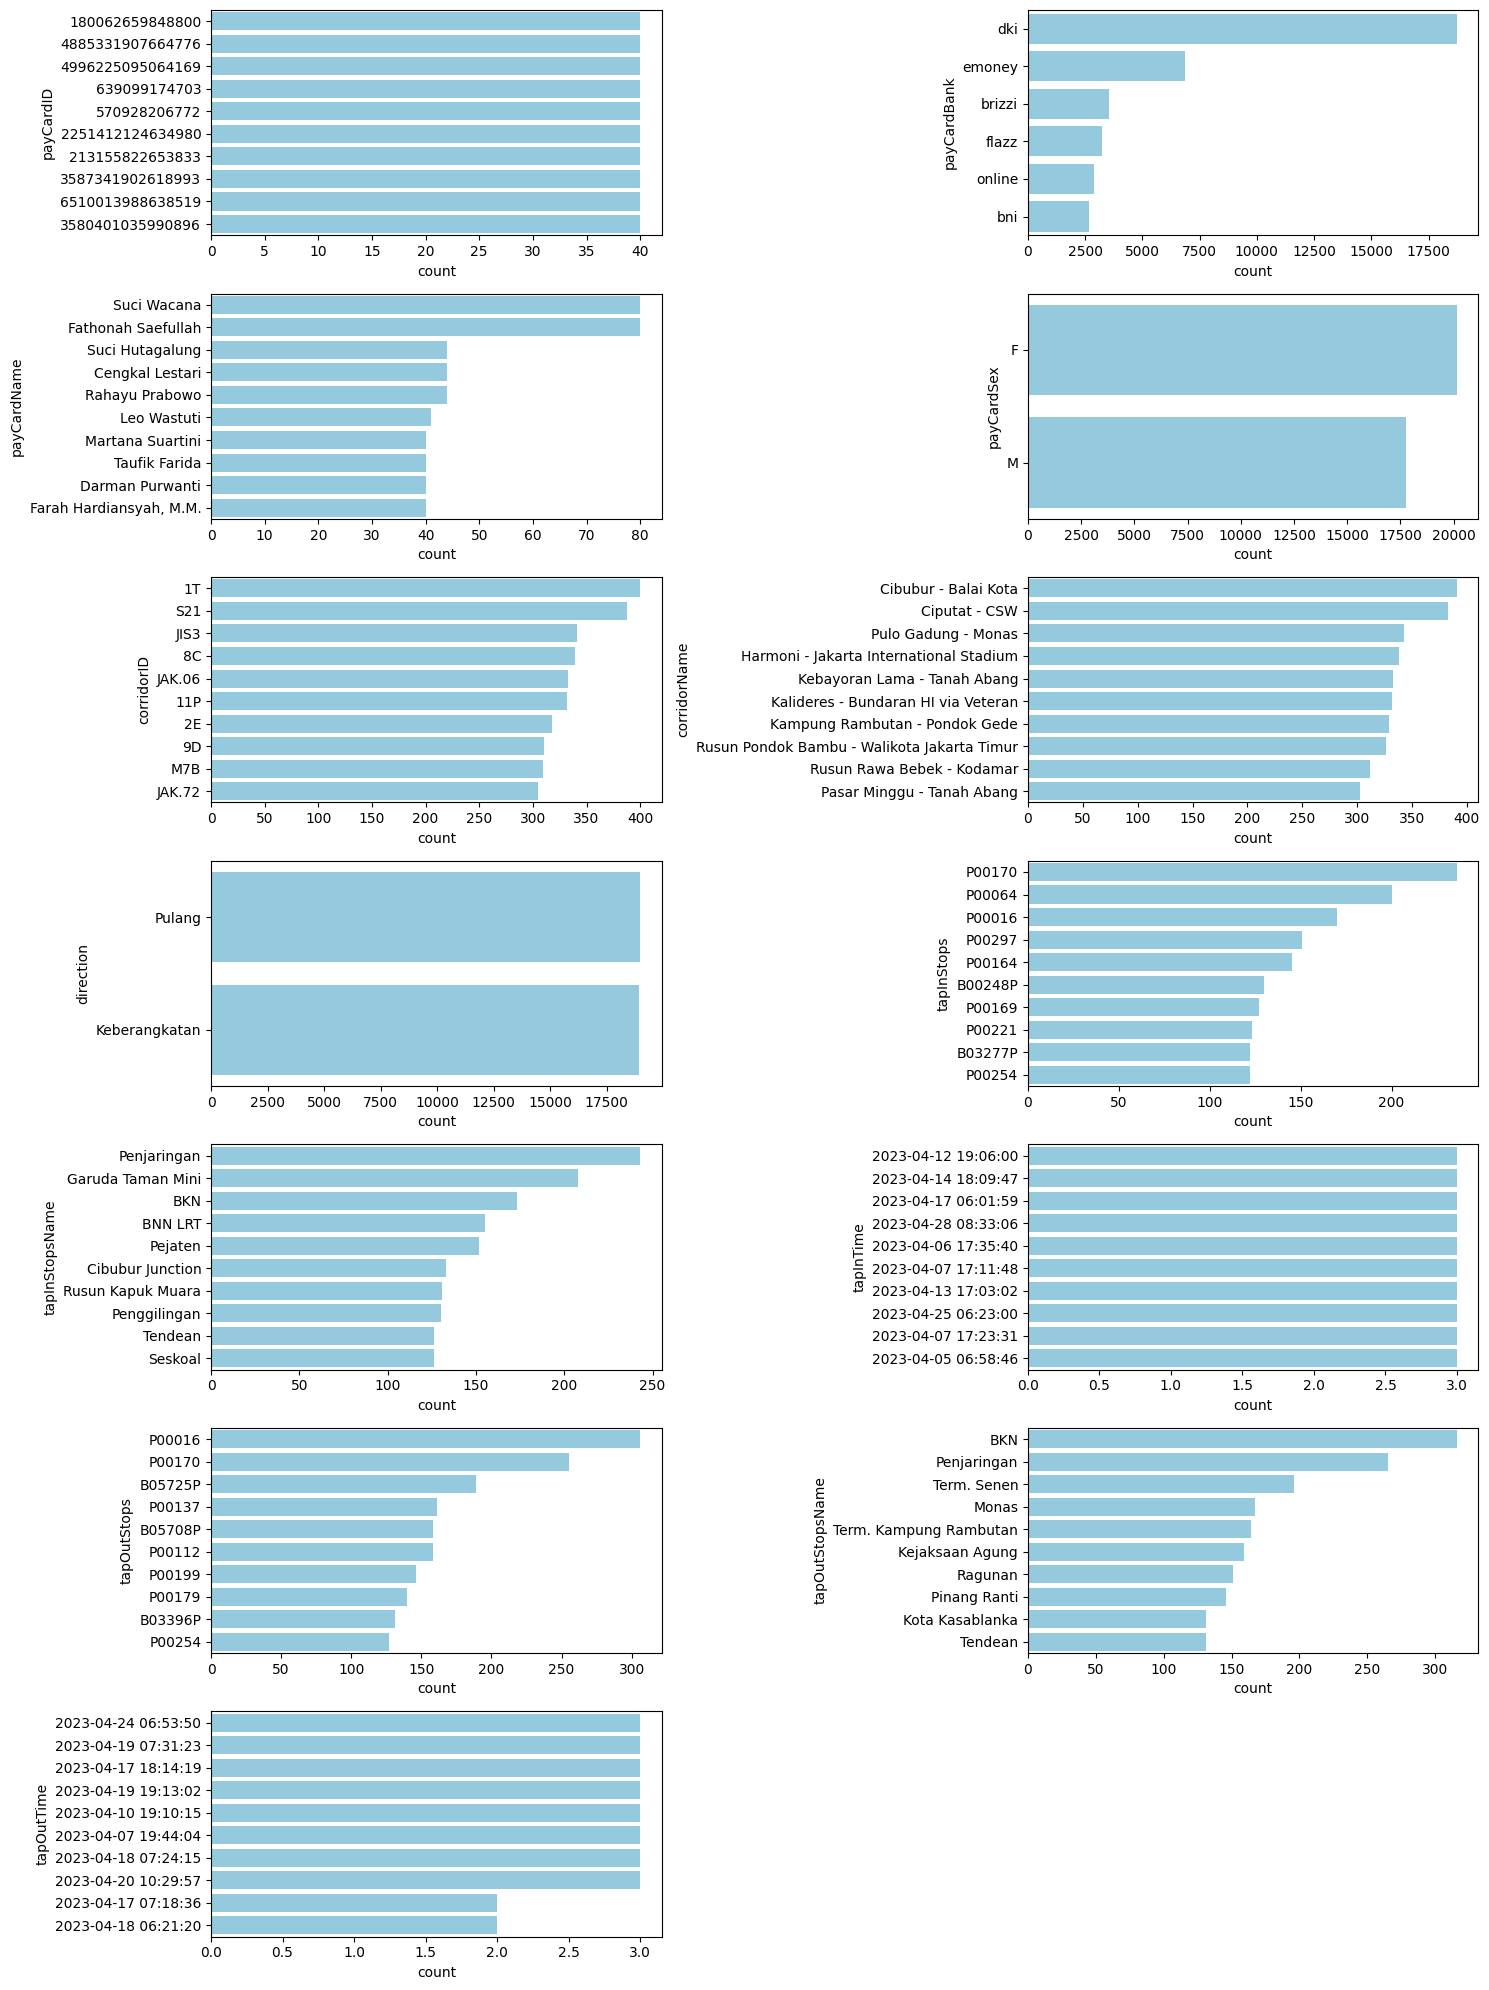

In [21]:
count = 0
fig = plt.figure(figsize=(15,20))
for kolom in kategorik.columns:
    count += 1
    plt.subplot(7,2,count)
    sns.countplot(y = kolom, data = kategorik, order = kategorik[kolom].value_counts().sort_values(ascending = False).head(10).index, color= 'skyblue')
    fig.tight_layout()
plt.show()

Secara garis besar:  
* kolom `payCardBank`: Bank "dki" adalah yang paling dominan di antara semua bank, diikuti oleh "emoney" dan "brizzi".
* kolom `payCardSex`:  Terdapat lebih banyak penumpang perempuan dibandingkan dengan penumpang laki-laki.
* kolom `corridorID`: Beberapa koridor memiliki frekuensi yang jauh lebih tinggi dibandingkan dengan yang lain. "1T" dan "S21" adalah dua koridor dengan frekuensi tertinggi.
* kolom `tapInStops`:"P00170" dan "P00016" adalah dua stasiun dengan jumlah penumpang naik terbanyak.
* kolom `tapInTime` dan `tapOutTime` :   ada rentang waktu yang memiliki frekuensi yang jauh lebih tinggi dibandingkan dengan yang lain. "05:30-09:00" dan "16:30-20:00" adalah rentang waktu dengan frekuensi tertinggi.
* kolom `tapOutStops` dan `tapOutStopsName` : Beberapa koridor memiliki frekuensi yang jauh lebih tinggi dibandingkan dengan yang lain. "1T" dan "6B" adalah dua koridor dengan frekuensi tertinggi.

---
### Summary Data Understanding

- Data Transjakarta ini menggambarkan informasi tentang transaksi penumpang, termasuk detail pribadi, rute yang diambil, dan biaya yang dikeluarkan.
- Beberapa kolom memiliki data yang hilang, terutama kolom yang terkait dengan informasi "tap out".
- Kolom numerik seperti payAmount menunjukkan distribusi yang tidak normal dengan beberapa outlier, sementara kolom lain seperti payCardBirthDate mendekati distribusi normal.
- Kolom kategorik menunjukkan variasi dalam distribusi, dengan beberapa kategori mendominasi distribusi.
- Korelasi antar kolom numerik menunjukkan beberapa hubungan yang menarik, tetapi sebagian besar kolom tidak berkorelasi dengan kuat.

Dengan pemahaman data yang lebih mendalam ini, kita dapat merancang langkah-langkah pembersihan data dan analisis lebih lanjut dengan lebih efektif.

----

## Data Cleaning

In [22]:
df_clean = df.copy()

### Cek duplikasi

In [23]:
total_duplicates = df_clean.duplicated().sum()

if total_duplicates > 0:
    print("\nTotal nilai yang merupakan duplikat dalam DataFrame:", total_duplicates)
else:
    print("\nTidak ada data duplikat dalam DataFrame.")


Tidak ada data duplikat dalam DataFrame.


> Tidak ada data yang duplikat pada dataset ini, sehingga kita akan melanjutkan ke langkah berikutnya, yaitu menangani nilai yang hilang (missing value).

### Handling Missing Value

In [24]:
missing_values = df_clean.isnull().sum()

# persentase missing values
missing_percentage = (df_clean.isnull().sum() / len(df_clean)) * 100

missing_info = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percentage}).sort_values(by='Percentage (%)', ascending=False)
missing_info[missing_info['Missing Values'] > 0]

,Missing Values,Percentage (%)
tapOutStops,2289,6.039578
corridorName,1930,5.092348
stopEndSeq,1344,3.546174
tapOutStopsLat,1344,3.546174
tapOutStopsLon,1344,3.546174
tapOutStopsName,1344,3.546174
tapOutTime,1344,3.546174
corridorID,1257,3.316623
tapInStops,1213,3.200528
payAmount,1007,2.656992


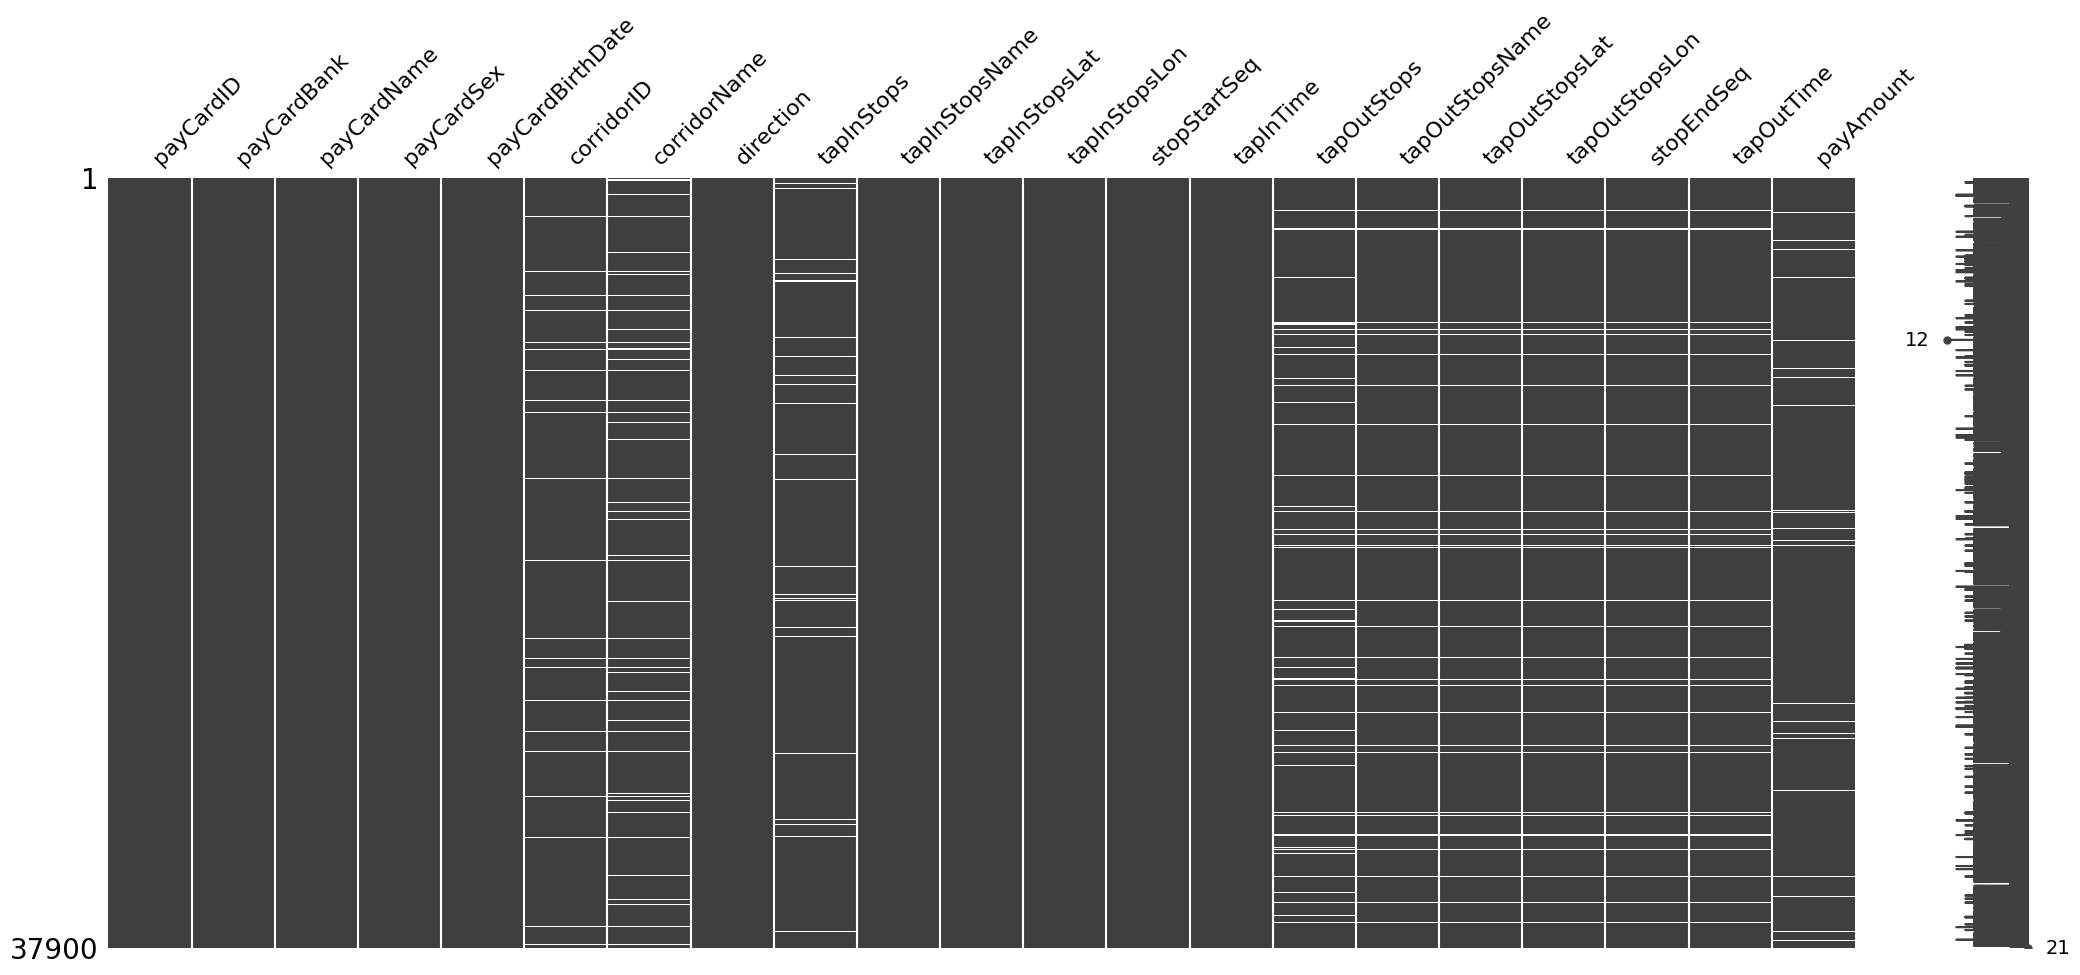

In [25]:
missingno.matrix(df_clean)
plt.show()

Kita telah mengidentifikasi beberapa kolom yang memiliki missing values. Pendekatan yang umum untuk mengatasi missing values adalah dengan menghapus atau mengimputasi data. Menghapus data mungkin bukan pilihan terbaik di sini karena kita tidak ingin kehilangan banyak informasi. Oleh karena itu, kita akan fokus pada imputasi.

### Pay Amount

In [26]:
df_clean['payAmount'].value_counts()

payAmount
3500.0     18503
0.0        16648
20000.0     1742
Name: count, dtype: int64

Pertama, mari kita cek, antara data yang kosong dari `payAmount` dengan kolom `corridorID` untuk menentukan rute apa saja yang tidak memiliki nilai di kolom `payAmount`.

In [27]:
df_clean[df_clean['payAmount'].isna()]['corridorID'].value_counts()

corridorID
M7B        309
JAK.48A    248
M1H        170
JAK.48B    159
3H          90
Name: count, dtype: int64

1. berdasarkan data dari https://money.kompas.com/read/2023/03/13/140000226/naik-angkot-jaklingko-masih-gratis- pada bulan maret 2023. biaya yang diperlukan untuk angkutan umum yang berjenis Jaklingko adalah Rp 0. 
2. berdasarkan data dari https://www.antaranews.com/berita/3482406/pengamat-nilai-wajar-jika-tarif-transjakarta-naik-menjadi-rp5000 pada bulan april 2023. biaya yang diperlukan untuk angkutan umum yang berjenis bus TransJakarta adalah Rp. 3.500
3. berdasarkan data dari sumber dibawah ini.
    1. https://transjakarta.co.id/produk-dan-layanan/layanan-bus/royaltrans/
    1. https://www.aroengbinang.com/2020/01/rute-transjakarta-royaltrans-cibubur-kota-1t.html
    1. https://megapolitan.kompas.com/read/2023/01/27/00150011/rute-royaltrans-b14-summarecon-bekasi-kuningan
    1. https://megapolitan.kompas.com/read/2023/01/26/00150011/rute-royaltrans-d32-cinere-bundaran-senayan
    1. https://megapolitan.kompas.com/read/2023/01/20/00150021/rute-royaltrans-b13-summarecon-bekasi-blok-m
    1. https://megapolitan.kompas.com/read/2023/01/26/01450071/rute-royaltrans-d31-cinere-kuningan

kita perlu menyesuaikan data cleaning untuk kolom payAmount sesuai dengan informasi tersebut.

Mari kita lakukan penyesuaian pada proses data cleaning untuk kolom payAmount dengan memastikan bahwa setiap entri untuk koridor dengan ID 1T, B14, D32, S31, B13, D31, 1K, 6P dan S12 adalah Royaltrans. tarif Royaltrans berdasarkan sumber ini https://news.detik.com/berita/d-6891014/transjakarta-tarif-bus-royaltrans-tetap-rp-20000 adalah `Rp 20.000`, selanjutnya koridor dengan awalan "JAK" memiliki biaya Rp 0  dan selain dari JAK adalah Rp 3500.

In [28]:
corridor_ids_to_update = ['1T', 'B14', 'D32', 'S31', 'B13', 'D31', '1K', '6P', 'S12']
corridor_ids_to_update

['1T', 'B14', 'D32', 'S31', 'B13', 'D31', '1K', '6P', 'S12']

In [29]:
# Update the payAmount for the specified corridors to 20000
df_clean.loc[df_clean['corridorID'].isin(corridor_ids_to_update), 'payAmount'] = 20000.0

# Verify the changes
updated_payAmount_for_corridors = df_clean[df_clean['corridorID'].isin(corridor_ids_to_update)]['payAmount'].unique()

updated_payAmount_for_corridors

array([20000.])

In [30]:
df_clean['payAmount'].value_counts()

payAmount
3500.0     18503
0.0        16648
20000.0     1742
Name: count, dtype: int64

In [31]:
df_clean['payAmount'].isnull().sum()

np.int64(1007)

> Biaya untuk koridor dengan ID 1T, B14, D32, S31, B13, D31, 1K, 6P dan S12 yang dinamakan Royaltrans telah berhasil diatur ke Rp 20.000. Semua entri untuk koridor tersebut kini memiliki biaya Rp 20.000, sesuai dengan informasi yang diberikan.

Selanjutnya, kita akan mengisi kolom `payAmount` dengan nilai 0 untuk baris yang memiliki nilai `corridorID` yang dimulai dengan 'JAK'

In [32]:
df_clean.loc[df_clean['corridorID'].str.startswith('JAK', na=False), 'payAmount'] = 0

df_clean[df_clean['corridorID'].str.startswith('JAK', na=False)]['payAmount'].unique()


array([0.])

Biaya untuk koridor yang dimulai dengan "JAK" telah berhasil diatur ke Rp 0. Semua entri untuk koridor tersebut kini memiliki biaya Rp 0, sesuai dengan informasi yang diberikan.

In [33]:
df_clean['payAmount'].isnull().sum()

np.int64(600)

Selanjutnya, kita akan mengimputasi missing values yang masih hilang pada kolom `payAmount`. pada tahap ini kita akan mengimputasi missing values dengan Rp 35000.

In [34]:
df_clean['payAmount'].fillna(3500, inplace=True)


df_clean['payAmount'].isnull().sum()

np.int64(0)

Missing values yang tersisa pada kolom payAmount telah berhasil diimputasi dengan nilai Rp 3500.

### Tap Out Stops

Kita akan menggunakan groupby dengan kombinasi transform untuk membangun kolom baru yang mengandung mode dari `tapOutStops` berdasarkan setiap keunikan dari data `tapOutStopsName`.

In [35]:
tapInStops_mode = df_clean.groupby('tapOutStopsName')['tapOutStops'].apply(lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan).reset_index()
tapInStops_mode

,tapOutStopsName,tapOutStops
0,ABA,B00002P
1,ACC Simatupang,B00004P
2,ACE Hardware,B00005P
3,ASEAN,P00004
4,ASMI,P00005
...,...,...
2243,Yayasan Perguruan Rakyat 2,B05929P
2244,Yon Arhanud - 10 Pesanggrahan,B05933P
2245,Yos Sudarso Kodamar,P00274
2246,Yos Sudarso Kodamar 1,B05934P


Pada tahap ini, kita melakukan konversi dua kolom dari DataFrame `tapOutStops_mode` menjadi kamus (`tapOutStops_mapping`). Dalam kamus ini, `tapOutStopsName` adalah kunci dan `tapOutStops` yang paling sering muncul adalah nilainya untuk menyelaraskan dengan `tapOutStopsName` dari `tapOutStops` yang kosong nilai valuenya.

In [36]:
tapOutStops_mapping = dict(zip(tapInStops_mode['tapOutStopsName'], tapInStops_mode['tapOutStops']))
tapOutStops_mapping

{'ABA': 'B00002P',
 'ACC Simatupang': 'B00004P',
 'ACE Hardware': 'B00005P',
 'ASEAN': 'P00004',
 'ASMI': 'P00005',
 'ASMI 2': 'B00070P',
 'ASSA': 'B06010P',
 'AURI Jatibaru': 'B00086P',
 'Acacia Residence': 'B00003P',
 'Adam Malik': 'P00001',
 'Ahmad Yani Bea Cukai': 'P00002',
 'Ahmad Yani Bea Cukai 1': 'B06534P',
 'Ahmad Yani Pisangan Baru': 'B00013P',
 'Akademi Farmasi Mahadhika': 'B00015P',
 'Akses Jembatan Ciliwung Balekambang': 'B00022P',
 'Al Khairiyah School': 'B00028P',
 'Al Mahbubiyah': 'B00029P',
 'Al Mukhlisin': 'B00030P',
 'Al-Wathoniyah': 'B06709P',
 'Allianz': 'B00034P',
 'Ambassador': 'B02183P',
 'Ampera 1': 'B00035P',
 'Ampera 2': 'B00036P',
 'Ampera 4': 'B00038P',
 'Ancol': 'P00003',
 'Andara Margasatwa 1': 'B00042P',
 'Antena II': 'B00053P',
 'Apartemen Simprug Teras': 'B00058P',
 'Apotik Rini Rawamangun': 'B00060P',
 'Arsip Nasional RI 1': 'B00066P',
 'Arsip Nasional RI 2': 'B00067P',
 'Asrama Marinir Marunda 2': 'B00074P',
 'Asshomadiyah Medicare Centre 2': 'B00077

Selanjutnya, kita akan menggantikan nilai yang hilang pada setiap baris dalam `tapOutStops` berdasarkan `tapOutStopsName` yang kita buat pada langkah sebelumnya. jika penyesuaian nilai dari `tapOutStops` dengan `tapOutStopsName` tidak ditemukan (NaN), maka imputasi nilai `tapOutStops` akan dilewati ke baris yang selanjutnya.

In [37]:
df_clean['tapOutStops'] = df_clean.apply(
    lambda row: tapOutStops_mapping[row['tapOutStopsName']] 
    if pd.isnull(row['tapOutStops']) and pd.notnull(row['tapOutStopsName'])  
    else row['tapOutStops'],
    axis=1
)

In [38]:
df_clean['tapOutStops'].isnull().sum()

np.int64(1363)

Setelah dilakukannya imputasi nilai `tapOutStops` menggunakan berdasarkan  kamus (`tapOutStops_mapping`) yang kita buat pada sebelumnya, masih tersisa 1363 missing value dari 2289 pada kolom `tapOutStops`.  Kita bisa hapus data ini, karena belum ada cara yang sesuai untuk mengisi `corridorID` yang hilang karena random (MCAR) dan tidak seharusnya kolom ini dibiarkan kosong untuk meminimalisir distorsi dalam distribusi data.

In [39]:
df_clean.dropna(subset=['tapOutStops'],inplace=True)

df_clean['tapOutStops'].isnull().sum()

np.int64(0)

### Value Corridor ID dan Corridor Name

Sebelum kita melakukan penginputan data, kita akan memeriksa jumlah nilai unik dari Corridor Name untuk memastikan apakah ada Corridor Name yang memiliki lebih dari satu Corridor ID. Hal ini bertujuan agar setiap Corridor ID hanya mewakili satu Corridor Name.

In [40]:
unique_corridor_ids = df_clean.groupby('corridorName')['corridorID'].nunique()

duplicates = unique_corridor_ids[unique_corridor_ids > 1]

result_data = []

result_df = pd.DataFrame()

if not duplicates.empty:
    print("Ada Corridor Name yang memiliki lebih dari satu Corridor ID:")    
    
    for corridor_name in duplicates.index:
        unique_ids = df_clean[df_clean['corridorName'] == corridor_name]['corridorID'].unique()
        result_data.append([corridor_name, unique_ids])

    result_df = pd.DataFrame(result_data, columns=['corridorName', 'unique_corridorIDs'])

    display(result_df)
else:
    print("Setiap Corridor Name hanya memiliki satu Corridor ID.")

Ada Corridor Name yang memiliki lebih dari satu Corridor ID:


,corridorName,unique_corridorIDs
0,Blok M - Kota,"[M1, 1]"
1,Kalideres - Bundaran HI via Veteran,"[M3, 3, nan]"
2,Matraman Baru - Ancol,"[5, nan, M5]"
3,Pinang Ranti - Pluit,"[M9, 9, nan]"
4,Pulo Gadung - Monas,"[2, M2, nan]"


Ternyata terdapat kode corridor dengan huruf "M" di awalnya (M1, M3, M5, M9, M2). Kode "M" ini menunjukkan bahwa rute tersebut adalah rute bus malam yang beroperasi pada jam tertentu, berbeda dengan rute bus reguler yang beroperasi pada jam siang. Untuk memastikan analisis hanya fokus pada rute reguler, kita akan mengganti kode "M" dengan kode reguler yang sesuai, seperti mengganti M1 menjadi 1, M3 menjadi 3, dan seterusnya.

Langkah ini bertujuan untuk memisahkan rute reguler yang akan dianalisis dan memastikan data dari bus malam tetap ada tetapi tidak memengaruhi analisis rute reguler.



In [41]:
corridor_ids_to_change = ['M1', 'M3', 'M5', 'M9', 'M2']

df_clean['corridorID'] = df_clean['corridorID'].replace(corridor_ids_to_change, 
                                                        [id[1:] for id in corridor_ids_to_change])

unique_corridor_ids = df_clean.groupby('corridorName')['corridorID'].nunique()

duplicates = unique_corridor_ids[unique_corridor_ids > 1]

result_data = []

result_df = pd.DataFrame()

if not duplicates.empty:
    print("Ada Corridor Name yang memiliki lebih dari satu Corridor ID:")    
    
    for corridor_name in duplicates.index:
        unique_ids = df_clean[df_clean['corridorName'] == corridor_name]['corridorID'].unique()
        result_data.append([corridor_name, unique_ids])

    result_df = pd.DataFrame(result_data, columns=['corridorName', 'unique_corridorIDs'])

    display(result_df)
else:
    print("Setiap Corridor Name hanya memiliki satu Corridor ID.")

Setiap Corridor Name hanya memiliki satu Corridor ID.


Dengan langkah ini, kita tetap mempertahankan data untuk rute bus malam, namun hanya kode rute reguler yang akan dipertimbangkan dalam analisis.

#### Corridor ID

Kita akan menggunakan groupby dengan kombinasi transform untuk membangun kolom baru yang mengandung mode dari `corridorID` berdasarkan setiap keunikan dari data `corridorName`.

In [42]:
corridorID_mode = df_clean.groupby('corridorName')['corridorID'].apply(lambda x: x.mode()[0]).reset_index()
corridorID_mode

,corridorName,corridorID
0,Andara - Stasiun Universitas Pancasila,JAK.44
1,BKN - Blok M,M7B
2,BSD - Jelambar,S11
3,BSD Serpong - Fatmawati,S12
4,Batusari - Grogol,8K
...,...,...
211,Terminal Rawamangun - Cipinang Muara,JAK.74
212,Terminal Tanah Merah - Pulo Gadung,JAK.112
213,Terminal Tanjung Priok - Ancol Barat,JAK.88
214,Tongtek - Tebet Eco Park (TEP) - Cililitan,JAK.43B


pada tahap ini, kita melakukan konversi dua kolom dari DataFrame `corridorID_mode` menjadi kamus (`corridorID_mapping`). Dalam kamus ini, `corridorName` adalah kunci dan `corridorID` yang paling sering muncul adalah nilainya untuk menyelaraskan dengan `corridorName` dari `corridorID` yang kosong nilai valuenya.

In [43]:
corridorID_mapping = dict(zip(corridorID_mode['corridorName'], corridorID_mode['corridorID']))
corridorID_mapping

{'Andara - Stasiun Universitas Pancasila': 'JAK.44',
 'BKN - Blok M': 'M7B',
 'BSD - Jelambar': 'S11',
 'BSD Serpong - Fatmawati': 'S12',
 'Batusari - Grogol': '8K',
 'Bekasi Barat - Blok M': 'B13',
 'Bekasi Barat - Kuningan': 'B14',
 'Bekasi Timur - Cawang': 'B21',
 'Bintara - Cipinang Indah': 'JAK.85',
 'Bintaro - Blok M': '8E',
 'Bintaro - Fatmawati': 'S31',
 'Blok M - Andara': 'JAK.31',
 'Blok M - Kota': '1',
 'Blok M - PGC': '7Q',
 'Blok M - Pasar Minggu': '6U',
 'Blok M - Universitas Indonesia': '9H',
 'Bulak Ringin - Kampung Rambutan': 'JAK.38',
 'Bulak Turi - Tanjung Priok': 'JAK.15',
 'Cawang UKI - Lubang Buaya': 'JAK.20',
 'Cempaka Putih - Pulo Gadung via Kelapa Gading': 'JAK.61',
 'Cibubur - BKN': '7C',
 'Cibubur - Balai Kota': '1T',
 'Cibubur - Kuningan': '6P',
 'Cibubur Junction - Blok M': '1K',
 'Cilangkap - Cililitan': 'JAK.36',
 'Ciledug - Tendean': '13',
 'Cililitan - Condet': 'JAK.16',
 'Cililitan - Condet via Kayu Manis': 'JAK.37',
 'Cililitan - Dwikora': 'JAK.21',
 

Selanjutnya, kita akan menggantikan nilai yang hilang pada setiap baris dalam `corridorID` berdasarkan `corridorName` yang kita buat pada langkah sebelumnya. jika penyesuaian nilai dari `corridorID` dengan `corridorName` tidak ditemukan (NaN), maka imputasi nilai `corridorID` akan dilewati ke baris yang selanjutnya.

In [44]:
df_clean['corridorID'] = df_clean.apply(
    lambda row: corridorID_mapping[row['corridorName']] 
    if pd.isnull(row['corridorID']) and pd.notnull(row['corridorName'])  
    else row['corridorID'],
    axis=1
)

In [45]:
df_clean['corridorID'].isnull().sum()

np.int64(1078)

Setelah dilakukannya imputasi nilai `corridorID` menggunakan berdasarkan  kamus (`corridorID_mapping`) yang kita buat pada sebelumnya, masih tersisa 1078 missing value pada kolom `corridorID`.  Kita bisa hapus data ini, karena belum ada cara yang sesuai untuk mengisi `corridorID` yang hilang karena random (MCAR) dan tidak seharusnya kolom ini dibiarkan kosong atau menggunakan modus untuk meminimalisir distorsi dalam distribusi data. tahap penghapusan data akan dilakukan setelah imputasi `corridorName` dibawah ini

#### Corridor Name

Kita akan menggunakan groupby dengan kombinasi transform untuk membangun kolom baru yang mengandung mode dari `corridorName` berdasarkan setiap keunikan dari data `corridorID`.

In [46]:
corridorName_mode = df_clean.groupby('corridorID')['corridorName'].apply(lambda x: x.mode()).reset_index()
corridorName_mode

,corridorID,level_1,corridorName
0,1,0,Blok M - Kota
1,10,0,Tanjung Priok - PGC 2
2,10A,0,Rusun Marunda - Tanjung Priok
3,10B,0,Rusun Cipinang Besar Selatan - Penas Kalimalang
4,10D,0,Kampung Rambutan - Tanjung Priok
...,...,...,...
211,S21,0,Ciputat - CSW
212,S22,0,Ciputat - Kampung Rambutan
213,S31,0,Bintaro - Fatmawati
214,T11,0,Poris Plawad - Bundaran Senayan


pada tahap ini, kita melakukan konversi dua kolom dari DataFrame `corridorName_mode` menjadi kamus (`corridorName_mapping`). Dalam kamus ini, `corridorID` adalah kunci dan `corridorName` yang paling sering muncul adalah nilainya untuk menyelaraskan dengan `CorridorID` dari `CorridorName` yang kosong nilai valuenya.

In [47]:
corridorName_mapping = dict(zip(corridorName_mode['corridorID'], corridorName_mode['corridorName']))
corridorName_mapping

{'1': 'Blok M - Kota',
 '10': 'Tanjung Priok - PGC 2',
 '10A': 'Rusun Marunda - Tanjung Priok',
 '10B': 'Rusun Cipinang Besar Selatan - Penas Kalimalang',
 '10D': 'Kampung Rambutan - Tanjung Priok',
 '10H': 'Tanjung Priok - Blok M',
 '10K': 'Tanjung Priok - Senen via Taman BMW',
 '11': 'Pulo Gebang - Matraman',
 '11B': 'Rusun Rawa Bebek - Penggilingan',
 '11C': 'Rusun Pinus Elok - Rusun Pulo Gebang',
 '11D': 'Pulo Gebang - Pulo Gadung 2 via PIK',
 '11K': 'Rusun Komarudin - Penggilingan',
 '11M': 'Rusun Rawa Bebek - Bukit Duri',
 '11N': 'Rusun Cipinang Muara - Jatinegara',
 '11P': 'Rusun Pondok Bambu - Walikota Jakarta Timur',
 '11Q': 'Kampung Melayu - Pulo Gebang via BKT',
 '12': 'Tanjung Priok - Pluit',
 '12A': 'Pelabuhan Kaliadem - Kota',
 '12B': 'Pluit - Senen',
 '12C': 'Rusun Waduk Pluit - Penjaringan',
 '12F': 'Rusun Marunda - Rusun Waduk Pluit',
 '12H': 'Rusun Penjaringan - Penjaringan',
 '12P': 'St. LRT Pegangsaan Dua - JIS',
 '13': 'Ciledug - Tendean',
 '13B': 'Puri Beta - Panc

Selanjutnya, kita akan menggantikan nilai yang hilang pada setiap baris dalam `corridorName` berdasarkan `corridorID` yang kita buat pada langkah sebelumnya. jika nilai dari `corridorName` 

In [48]:
df_clean['corridorName'] = df_clean.apply(
    lambda row: corridorName_mapping[row['corridorID']] 
    if pd.isnull(row['corridorName']) and pd.notnull(row['corridorID'])  
    else row['corridorName'],
    axis=1
)

In [49]:
df_clean['corridorName'].isnull().sum()

np.int64(1078)

Setelah dilakukannya imputasi nilai `corridorName` menggunakan berdasarkan  kamus (`corridorName_mapping`) yang kita buat pada sebelumnya, masih tersisa 1078 missing value pada kolom `corridorName`.  Kita bisa hapus data ini, karena belum ada cara yang sesuai untuk mengisi `corridorName` yang hilang karena random (MCAR) dan tidak seharusnya kolom ini dibiarkan kosong meminimalisir distorsi dalam distribusi data. 

pada tahap ini, kita dapat menghapus value data yang masih kosong pada kolom `corridorID` dan `corridorName`.

In [50]:
df_clean.dropna(subset=['corridorID','corridorName'],inplace=True)

df_clean[['corridorID','corridorName']].isnull().sum()

corridorID      0
corridorName    0
dtype: int64

### TapInStops

Kita akan menggunakan groupby dengan kombinasi transform untuk membangun kolom baru yang mengandung mode dari `tapInStops` berdasarkan setiap keunikan dari data `tapInStopsName`.

In [51]:
tapInStops_mode = df_clean.groupby('tapInStopsName')['tapInStops'].apply(lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan).reset_index()
tapInStops_mode

,tapInStopsName,tapInStops
0,18 Office Park,B00001P
1,ACC Simatupang,B00004P
2,ACE Hardware,B00005P
3,AKR Tower,B00018P
4,ASEAN,P00004
...,...,...
2516,Yayasan Muhammadiyah 2,B05925P
2517,Yayasan Nurul Ihsan Pulo Gebang,B05926P
2518,Yayasan Perguruan Rakyat 2,B05929P
2519,Yon Arhanud - 10 Pesanggrahan,B05933P


pada tahap ini, kita melakukan konversi dua kolom dari DataFrame `tapInStops_mode` menjadi kamus (`tapInStops_mapping`). Dalam kamus ini, `tapInStopsName` adalah kunci dan `tapInStops` yang paling sering muncul adalah nilainya untuk menyelaraskan dengan `tapInStopsName` dari `tapInStops` yang kosong nilai valuenya.

In [52]:
tapInStops_mapping = dict(zip(tapInStops_mode['tapInStopsName'], tapInStops_mode['tapInStops']))
tapInStops_mapping

{'18 Office Park': 'B00001P',
 'ACC Simatupang': 'B00004P',
 'ACE Hardware': 'B00005P',
 'AKR Tower': 'B00018P',
 'ASEAN': 'P00004',
 'ASMI': 'P00005',
 'Adam Malik': 'P00001',
 'Adam Malik 1': 'B00008P',
 'Ahmad Yani Bea Cukai': 'P00002',
 'Akper Fatmawati Pondok Labu': 'B00017P',
 'Al Izhar Pondok Labu 2': 'B00027P',
 'Al Khairiyah School': 'B00028P',
 'Al Mukhlisin': 'B00030P',
 'Al Wathoniyah 1': 'B00031P',
 'Al Wathoniyah 2': 'B00032P',
 'Al-Wathoniyah': 'B06709P',
 'Allianz': 'B00034P',
 'Ambassador': 'B02183P',
 'Ampera 1': 'B00035P',
 'Ampera 2': 'B00036P',
 'Ampera 3': 'B00037P',
 'Ampera Garden': 'B00039P',
 'Ampera Yos Sudarso': 'B00040P',
 'Ananda Pulo Gadung': 'B00041P',
 'Ancol': 'P00003',
 'Ancol Pintu 2': 'B06000P',
 'Andara Margasatwa 2': 'B00043P',
 'Andara Margasatwa 3': 'B00044P',
 'Andara Margasatwa 4': 'B00045P',
 'Aneka Apotek': 'B00046P',
 'Aneka PIK Penggilingan': 'B00048P',
 'Antena III': 'B00052P',
 'Apartemen Kedoya Elok 2': 'B00056P',
 'Apartemen Simprug Te

Selanjutnya, kita akan menggantikan nilai yang hilang pada setiap baris dalam `tapInStops` berdasarkan `tapInStopsName` yang kita buat pada langkah sebelumnya. jika penyesuaian nilai dari `tapInStops` dengan `tapInStopsName` tidak ditemukan (NaN), maka imputasi nilai `tapInStops` akan dilewati ke baris yang selanjutnya.

In [53]:
df_clean['tapInStopsName'] = df_clean.apply(
    lambda row: corridorName_mapping[row['tapInStops']] 
    if pd.isnull(row['tapInStopsName']) and pd.notnull(row['tapInStops'])  
    else row['tapInStopsName'],
    axis=1
)

In [54]:
df_clean['tapInStops'].isnull().sum()

np.int64(1145)

Setelah dilakukannya imputasi nilai `tapInStops` menggunakan berdasarkan  kamus (`tapInStops_mapping`) yang kita buat pada sebelumnya, masih tersisa 1145 missing value pada kolom `tapInStops`.  Kita bisa hapus data ini, karena belum ada cara yang sesuai untuk mengisi `corridorID` yang hilang karena random (MCAR) dan tidak seharusnya kolom ini dibiarkan kosong atau menggunakan modus untuk meminimalisir distorsi dalam distribusi data.

In [55]:
df_clean.dropna(subset=['tapInStops'],inplace=True)

df_clean['tapInStops'].isnull().sum()

np.int64(0)

In [56]:
print_data_info(df_clean)

Jumlah baris: 34,314, Jumlah kolom: 21
--------------------------------------------------------------------------------


,Feature,Data Type,Null Count,Null Percentage (%)
0,payCardID,object,0,0.0
1,payCardBank,object,0,0.0
2,payCardName,object,0,0.0
3,payCardSex,object,0,0.0
4,payCardBirthDate,int64,0,0.0
5,corridorID,object,0,0.0
6,corridorName,object,0,0.0
7,direction,object,0,0.0
8,tapInStops,object,0,0.0
9,tapInStopsName,object,0,0.0


### Handling Outliers

In [57]:
numerik_outliers = df_clean.select_dtypes(include= 'number')
numerik_outliers

,payCardBirthDate,tapInStopsLat,tapInStopsLon,stopStartSeq,tapOutStopsLat,tapOutStopsLon,stopEndSeq,payAmount
0,2008,-6.184631,106.84402,7,-6.203101,106.85715,12.0,3500.0
1,1997,-6.228700,106.83302,13,-6.217152,106.81892,21.0,3500.0
2,1992,-6.133132,106.81435,38,-6.133731,106.81475,39.0,3500.0
3,1978,-6.195743,106.93526,23,-6.183068,106.93194,29.0,3500.0
4,1982,-6.149650,106.88900,5,-6.135355,106.81143,15.0,3500.0
...,...,...,...,...,...,...,...,...
37895,2004,-6.196892,106.82309,2,-6.290967,106.82365,13.0,3500.0
37896,1974,-6.290154,106.88116,1,-6.291075,106.88634,2.0,3500.0
37897,1976,-6.216247,106.81676,12,-6.370321,106.89628,14.0,20000.0
37898,1976,-6.188656,106.80954,33,-6.188861,106.81135,34.0,0.0


Kolom-kolom berikut ini adalah kandidat yang akan kita analisis untuk mendeteksi outlier:

- `payCardBirthDate`
- `tapInStopsLat`
- `tapInStopsLon`
- `stopStartSeq`
- `tapOutStopsLat`
- `tapOutStopsLon`
- `stopEndSeq`
- `payAmount`

Kita akan menggunakan boxplot untuk memvisualisasikan distribusi data dan mendeteksi outlier.

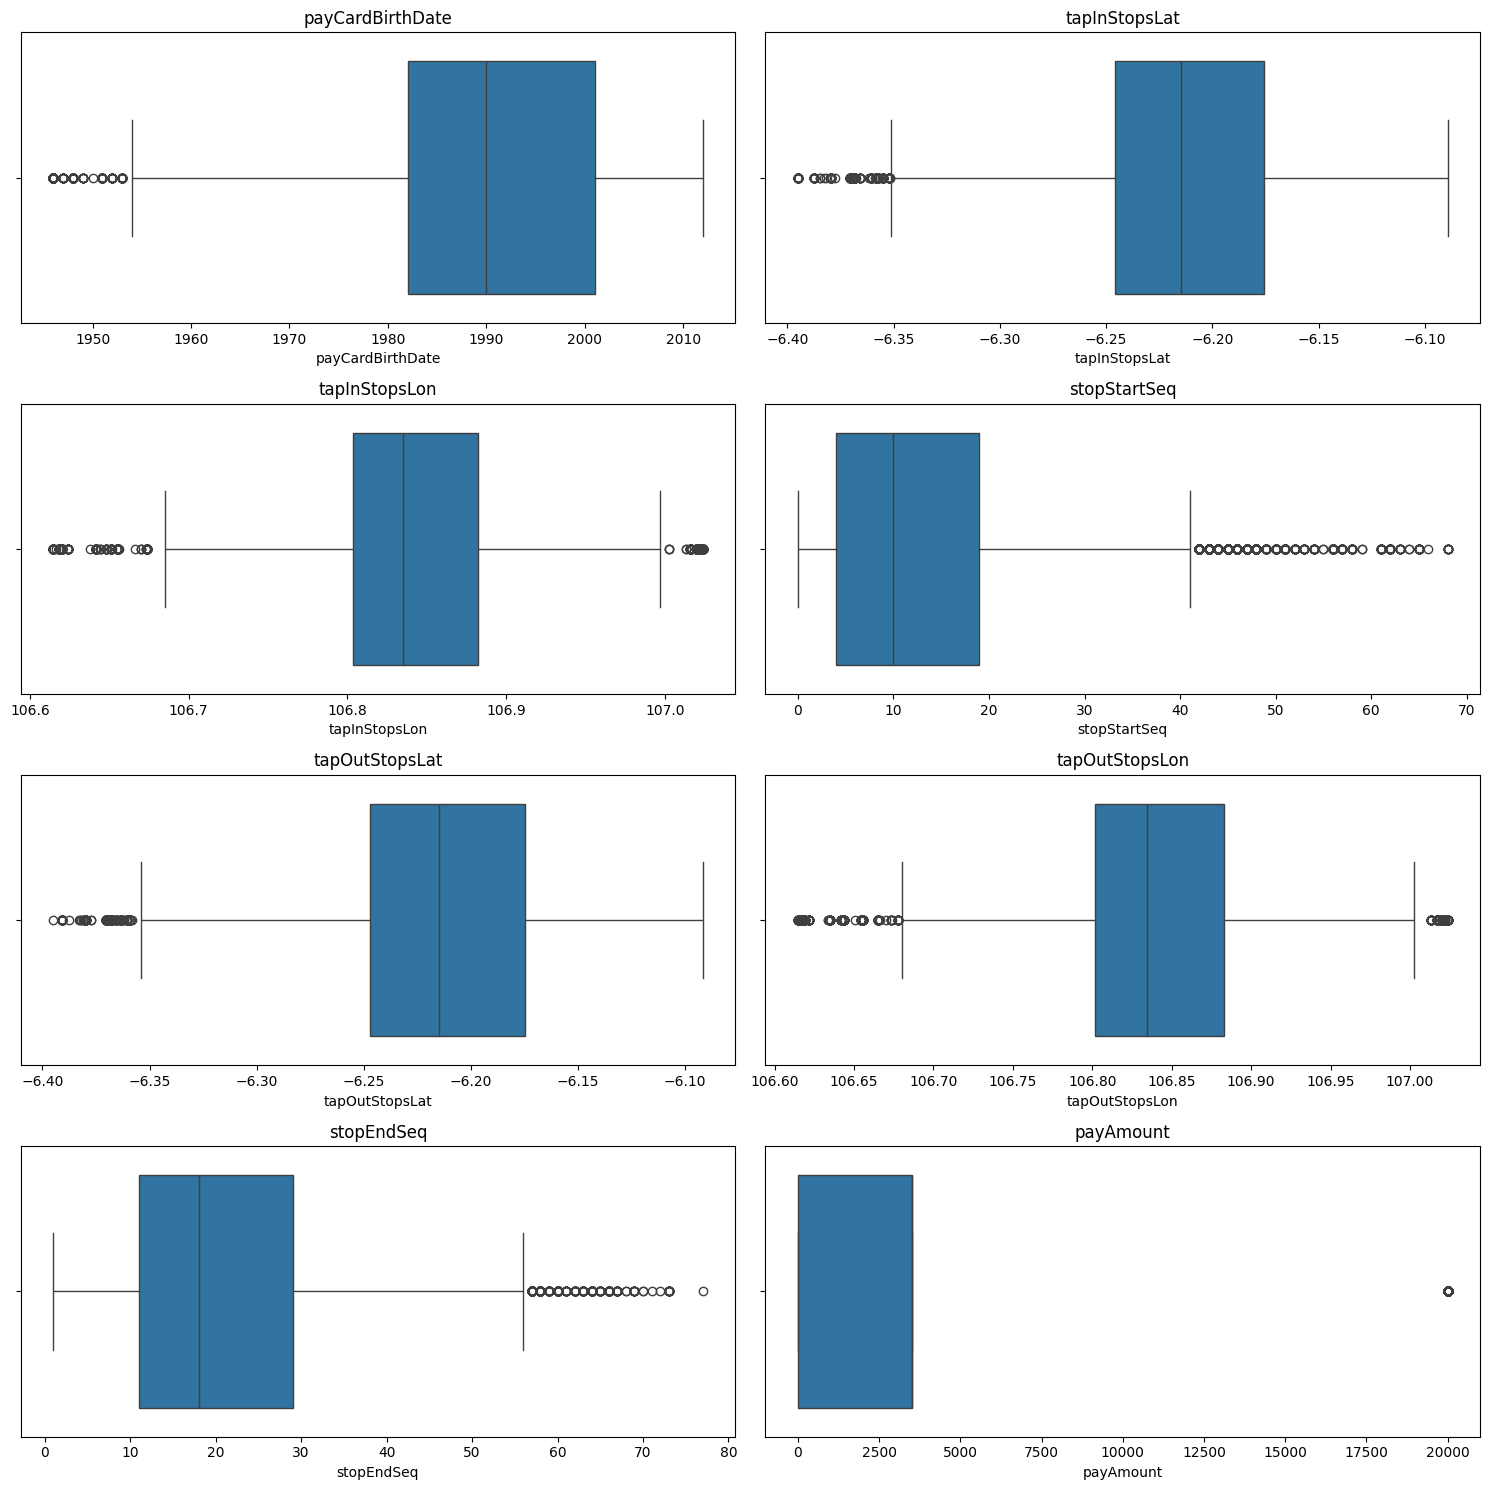

In [58]:
fig = plt.figure(figsize=(15,15)) # horizontal, vertikal

count = 0
for kolom in numerik_outliers.columns:
    count += 1
    plt.subplot(4,2,count)
    sns.boxplot(numerik, x = kolom)
    fig.tight_layout() # biar tidak tertumpuk
    plt.title(f'{kolom}')
plt.show()

Dari boxplot di atas, kita dapat membuat beberapa kesimpulan:

- `payCardBirthDate`: Tidak tampak adanya outlier. Semua data tampak berada dalam rentang yang masuk akal.
- `tapInStopsLat` dan `tapInStopsLon`: Tidak tampak adanya outlier. Semua data tampak berada dalam rentang yang masuk akal.
- `stopStartSeq`: Terdapat beberapa nilai yang mungkin dianggap sebagai outlier di bagian atas, tetapi ini mungkin menunjukkan urutan pemberhentian tertentu yang jarang terjadi.
- `tapOutStopsLat` dan `tapOutStopsLon`: Tidak tampak adanya outlier.
- `stopEndSeq`: Sama seperti stopStartSeq, terdapat beberapa nilai yang mungkin dianggap sebagai outlier di bagian atas.
- `payAmount`: Terdapat beberapa nilai yang jelas dianggap sebagai outlier di bagian atas, khususnya nilai 20,000.0. Kita perlu memeriksa apakah ini kesalahan input atau transaksi yang valid.

Selanjutnya adalah menggunakan metode statistik untuk mengidentifikasi outlier. Salah satu metode yang umum digunakan adalah IQR (Interquartile Range).

Dengan metode IQR, kita dapat menghitung batas bawah dan batas atas untuk setiap kolom dan kemudian menentukan data mana yang dianggap sebagai outlier.

In [59]:
iqr_data = {}

for col in numeric_columns:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    
    iqr_data[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_whisker': lower_whisker,
        'upper_whisker': upper_whisker
    }

iqr_df = pd.DataFrame(iqr_data).T
iqr_df

,Q1,Q3,IQR,lower_whisker,upper_whisker
payCardBirthDate,1982.000000,2001.000000,19.000000,1953.500000,2029.500000
tapInStopsLat,-6.245863,-6.175528,0.070335,-6.351365,-6.070025
tapInStopsLon,106.803560,106.882770,0.079210,106.684745,107.001585
stopStartSeq,4.000000,19.000000,15.000000,-18.500000,41.500000
tapOutStopsLat,-6.247225,-6.174736,0.072489,-6.355958,-6.066002
tapOutStopsLon,106.801755,106.883410,0.081655,106.679272,107.005892
stopEndSeq,11.000000,29.000000,18.000000,-16.000000,56.000000
payAmount,0.000000,3500.000000,3500.000000,-5250.000000,8750.000000


Jika suatu nilai dalam kolom berada di bawah "lower_whisker" atau di atas "upper_whisker", maka nilai tersebut dapat dianggap sebagai outlier.
1. untuk kolom `payAmount`, setiap nilai yang kurang dari -5250 atau lebih dari 8750 dapat dianggap sebagai outlier. Namun, kita tahu  nilai negatif untuk `payAmount` tidak mmungkin, jadi kita hanya perlu memeriksa nilai yang lebih dari 8750.

Selanjutnya adalah mengevaluasi data yang dianggap outlier berdasarkan batas-batas tersebut. mari kita identifikasi outlier untuk setiap kolom.

In [60]:
outliers_data = {}

for col, bounds in iqr_df.iterrows():
    outliers = df_clean[(df_clean[col] < bounds['lower_whisker']) | (df_clean[col] > bounds['upper_whisker'])]
    outliers_data[col] = outliers[col].value_counts()

outliers_df = pd.DataFrame(outliers_data)
outliers_df

,payCardBirthDate,tapInStopsLat,tapInStopsLon,stopStartSeq,tapOutStopsLat,tapOutStopsLon,stopEndSeq,payAmount
-6.394973,NaN,33.0,NaN,NaN,1.0,NaN,NaN,NaN
-6.391068,NaN,NaN,NaN,NaN,39.0,NaN,NaN,NaN
-6.387532,NaN,5.0,NaN,NaN,1.0,NaN,NaN,NaN
-6.387291,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN
-6.384603,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1949.000000,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1951.000000,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952.000000,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953.000000,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Berdasarkan analisis IQR, berikut adalah outlier yang teridentifikasi untuk setiap kolom:

- `payCardBirthDate`: Terdapat beberapa tahun kelahiran yang lebih tua yang dianggap sebagai outlier. Hal ini mungkin menunjukkan beberapa pelanggan yang lebih tua menggunakan layanan ini.
- `tapInStopsLat` dan `tapOutStopsLat`: Terdapat beberapa titik lintang yang dianggap sebagai outlier. Kita perlu memeriksa apakah koordinat ini masuk akal.
- `tapInStopsLon` dan `tapOutStopsLon`: Tidak ada outlier yang terdeteksi.
- `stopStartSeq` dan `stopEndSeq`: Tidak ada outlier yang terdeteksi.
- `payAmount`: Seperti yang kita lihat sebelumnya di boxplot, terdapat 1,606 entri dengan nilai 20,000 yang dianggap sebagai outlier. Perlu investigasi lebih lanjut untuk memahami apakah ini kesalahan input atau transaksi yang valid.

#### PayAmount

Untuk kolom payAmount, berdasarkan dari data sumber dibawah ini, 
1. https://transjakarta.co.id/produk-dan-layanan/layanan-bus/royaltrans/
1. https://www.aroengbinang.com/2020/01/rute-transjakarta-royaltrans-cibubur-kota-1t.html
1. https://megapolitan.kompas.com/read/2023/01/27/00150011/rute-royaltrans-b14-summarecon-bekasi-kuningan
1. https://megapolitan.kompas.com/read/2023/01/26/00150011/rute-royaltrans-d32-cinere-bundaran-senayan
1. https://megapolitan.kompas.com/read/2023/01/20/00150021/rute-royaltrans-b13-summarecon-bekasi-blok-m
1. https://megapolitan.kompas.com/read/2023/01/26/01450071/rute-royaltrans-d31-cinere-kuningan

koridor dengan ID 1T, B14, D32, S31, B13, D31, 1K, 6P dan S12 adalah Royaltrans. tarif Royaltrans berdasarkan sumber ini https://news.detik.com/berita/d-6891014/transjakarta-tarif-bus-royaltrans-tetap-rp-20000 adalah `Rp 20.000`.

untuk koridor T21 adalah percepatan dari koridor T11 yang merupakan Transjakarta biasa akan diganti menjadi `RP 3500`

In [61]:
df_clean.loc[(df_clean['corridorID'] == 'T21') & (df_clean['payAmount'] == 20000), 'payAmount'] = 3500.0

updated_payAmount_for_T21 = df_clean[df_clean['corridorName'] == 'T21']['payAmount'].unique()

updated_payAmount_for_T21

array([], dtype=float64)

In [62]:
corridor_20k = df_clean[df_clean['payAmount'] == 20000][['corridorID', 'corridorName']].drop_duplicates()

corridor_20k

,corridorID,corridorName
5,1T,Cibubur - Balai Kota
8,B14,Bekasi Barat - Kuningan
212,D32,Cinere - Bundaran Senayan
579,S31,Bintaro - Fatmawati
12072,B13,Bekasi Barat - Blok M
12111,D31,Cinere - Kuningan
12220,1K,Cibubur Junction - Blok M
12245,6P,Cibubur - Kuningan
12322,S12,BSD Serpong - Fatmawati


#### `tapInStopsLat` dan `tapOutStopsLat` 

Penanganan outlier untuk koordinat geografis bisa sedikit berbeda dengan data numerik lainnya, karena kita perlu memastikan bahwa koordinat tersebut masuk akal (posisi berada di Jabodetabek).

Mari kita mulai dengan mengevaluasi outlier di tapInStopsLat dan tapOutStopsLat berdasarkan batas IQR yang telah kita hitung sebelumnya.

In [63]:
tapInStopsLat_outliers = df_clean[(df_clean['tapInStopsLat'] < iqr_df.loc['tapInStopsLat', 'lower_whisker']) | 
                              (df_clean['tapInStopsLat'] > iqr_df.loc['tapInStopsLat', 'upper_whisker'])]

tapOutStopsLat_outliers = df_clean[(df_clean['tapOutStopsLat'] < iqr_df.loc['tapOutStopsLat', 'lower_whisker']) | 
                               (df_clean['tapOutStopsLat'] > iqr_df.loc['tapOutStopsLat', 'upper_whisker'])]

tapInStopsLat_outliers_count = tapInStopsLat_outliers['tapInStopsLat'].value_counts()
tapOutStopsLat_outliers_count = tapOutStopsLat_outliers['tapOutStopsLat'].value_counts()

In [64]:
tapInStopsLat_outliers_count

tapInStopsLat
-6.368735    117
-6.370321     39
-6.394973     33
-6.379273     22
-6.387291     20
-6.354871     19
-6.358301     18
-6.360526     17
-6.357133     16
-6.351933     16
-6.354808      9
-6.365857      8
-6.379631      7
-6.387532      5
-6.384603      2
-6.360054      2
-6.351650      2
-6.379677      1
-6.360664      1
-6.377369      1
-6.368690      1
-6.379606      1
-6.369769      1
-6.379436      1
-6.351941      1
-6.381864      1
-6.361780      1
-6.356542      1
-6.382532      1
-6.367500      1
Name: count, dtype: int64

In [65]:
tapOutStopsLat_outliers_count

tapOutStopsLat
-6.368735    124
-6.370321     44
-6.391068     39
-6.367500     20
-6.359265     19
-6.363462     19
-6.360526     19
-6.380018     18
-6.379679      7
-6.365855      7
-6.377369      2
-6.380896      2
-6.382532      1
-6.362219      1
-6.358301      1
-6.379677      1
-6.364144      1
-6.379503      1
-6.387532      1
-6.365910      1
-6.369751      1
-6.362267      1
-6.383095      1
-6.364269      1
-6.363399      1
-6.367222      1
-6.394973      1
-6.381864      1
-6.361780      1
-6.365166      1
Name: count, dtype: int64

Selanjutnya, kita dapat memverifikasi outliers dari `tapInStopsLat` dan `tapOutStopsLat` menggunakan map Jabodetabek. 
1. jika koordinat masuk akal (misalnya berada di luar wilayah Jabodetabek), kita bisa memilih untuk mempertahankan baris data tersebut.
2. jika koordinat tidak masuk akal (misalnya tidak berada di luar wilayah Jabodetabek), kita bisa memilih untuk menghapus baris data tersebut.

In [66]:
Q1_tapIn = df_clean['tapInStopsLat'].quantile(0.25)
Q3_tapIn = df_clean['tapInStopsLat'].quantile(0.75)
IQR_tapIn = Q3_tapIn - Q1_tapIn
lower_bound_tapIn = Q1_tapIn - 1.5 * IQR_tapIn
upper_bound_tapIn = Q3_tapIn + 1.5 * IQR_tapIn

# menyaring the outliers for tapInStopsLat berdasarkan on IQR bounds
tapInStopsLat_outliers = df_clean[(df_clean['tapInStopsLat'] < lower_bound_tapIn) | 
                              (df_clean['tapInStopsLat'] > upper_bound_tapIn)]

# membuat peta yang berpusat di sekitar Jakarta
m_all_outliers = folium.Map(location=[-6.2088, 106.8456], zoom_start=11)

# menambahkan tanda untuk seluruh outlier dari tapInStopsLat
for idx, row in tapInStopsLat_outliers.iterrows():
    folium.Marker([row['tapInStopsLat'], row['tapInStopsLon']], 
                  tooltip=f"Lat: {row['tapInStopsLat']}, Lon: {row['tapInStopsLon']}").add_to(m_all_outliers)

m_all_outliers


In [67]:
Q1_tapIn = df_clean['tapOutStopsLat'].quantile(0.25)
Q3_tapIn = df_clean['tapOutStopsLat'].quantile(0.75)
IQR_tapIn = Q3_tapIn - Q1_tapIn
lower_bound_tapIn = Q1_tapIn - 1.5 * IQR_tapIn
upper_bound_tapIn = Q3_tapIn + 1.5 * IQR_tapIn

tapInStopsLat_outliers = df_clean[(df_clean['tapOutStopsLat'] < lower_bound_tapIn) | 
                              (df_clean['tapOutStopsLat'] > upper_bound_tapIn)]

m_all_outliers = folium.Map(location=[-6.2088, 106.8456], zoom_start=11)

for idx, row in tapInStopsLat_outliers.iterrows():
    folium.Marker([row['tapOutStopsLat'], row['tapOutStopsLon']], 
                  tooltip=f"Lat: {row['tapOutStopsLat']}, Lon: {row['tapOutStopsLon']}").add_to(m_all_outliers)

m_all_outliers


Berdasarkan https://transjakarta.co.id/peta-rute/, outliers dari `tapInStopsLat` dan `tapOutStopsLat` dapat dikategorikan masuk akal karena lokasi koordinat tersebut masih berada di daerah Jabodetabek.

## Data yang sudah bersih
Kita sudah selesai membersihkan data kita, sekarang, mari kita lihat sekilas informasi dari data yang sudah kita bersihkan

----------------------------------------------------------------------------------------------
----------------------------------------   RAW DATA   ----------------------------------------
----------------------------------------------------------------------------------------------
Jumlah baris: 37,900, Jumlah kolom: 10
--------------------------------------------------------------------------------


,Feature,Data Type,Null Count,Null Percentage (%)
0,corridorID,object,1257,3.32
1,corridorName,object,1930,5.09
2,tapInStops,object,1213,3.20
3,tapOutStops,object,2289,6.04
4,tapOutStopsName,object,1344,3.55
5,tapOutStopsLat,float64,1344,3.55
6,tapOutStopsLon,float64,1344,3.55
7,stopEndSeq,float64,1344,3.55
8,tapOutTime,datetime64[ns],1344,3.55
9,payAmount,float64,1007,2.66


----------------------------------------------------------------------------------------------
--------------------------------------   CLEANED DATA   --------------------------------------
----------------------------------------------------------------------------------------------
Jumlah baris: 34,314, Jumlah kolom: 10
--------------------------------------------------------------------------------


,Feature,Data Type,Null Count,Null Percentage (%)
0,corridorID,object,0,0.0
1,corridorName,object,0,0.0
2,tapInStops,object,0,0.0
3,tapOutStops,object,0,0.0
4,tapOutStopsName,object,0,0.0
5,tapOutStopsLat,float64,0,0.0
6,tapOutStopsLon,float64,0,0.0
7,stopEndSeq,float64,0,0.0
8,tapOutTime,datetime64[ns],0,0.0
9,payAmount,float64,0,0.0


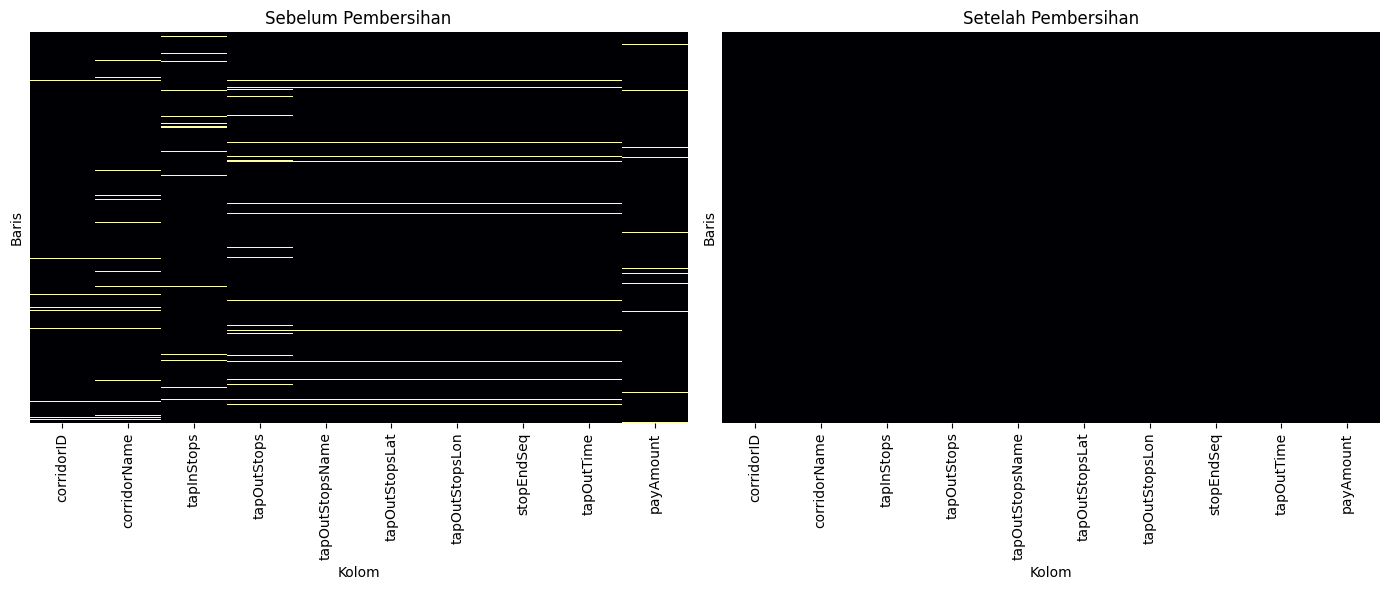

In [68]:
na_columns = df.columns[df.isna().any()].tolist()

# Menampilkan informasi tentang data sebelum dan setelah pembersihan
print('----------------------------------------------------------------------------------------------')
print('----------------------------------------   RAW DATA   ----------------------------------------')
print('----------------------------------------------------------------------------------------------')
print_data_info(df[na_columns])

print('----------------------------------------------------------------------------------------------')
print('--------------------------------------   CLEANED DATA   --------------------------------------')
print('----------------------------------------------------------------------------------------------')
print_data_info(df_clean[na_columns])

# Menampilkan heatmap side-by-side untuk data sebelum dan setelah pembersihan
draw_isna_heatmap_side_by_side(
    [df[na_columns], df_clean[na_columns]],
    ['Sebelum Pembersihan', 'Setelah Pembersihan']
)


**📊 Tinjauan _Missing Values_**

| **Dataset**      | **Jumlah Missing Values** | **Persentase** |
|------------------|------------------------:|---------------:|
| **Data Mentah**  |              2,289     |          6.04% |
| **Data Bersih**  |              0     |         0% |



**✨ Sebelum dibersihkan, kita memiliki 37,900 baris data, sekarang kita memiliki 34,314 baris. data yang sebelumnya kosong kita isi dengan nilai yang sebenarnya atau sedekat mungkin dengan nilai asli. lalu sisanya, sekitar 3,586 baris data yang kosong karena random dihapus.**


# **Data Analysis**
Kita sudah melakukan tahap *data cleaning*, Sekarang, kita bisa mulai melakukan analisis untuk mencari tahu **Apakah penempatan bus pink sudah sesuai kebutuhan penumpang wanita di tiap koridor?**.  

---

Sebelum melakukan analisa kita akan memilih data, data yang kita gunakan hanya angkutan transjakarta BRT

In [69]:
brt = ['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '10D',
 '10H',
 '13B',
 '2A',
 '3F',
 '3H',
 '4D',
 '5C',
 '5D',
 '6A',
 '6B',
 '6V',
 '7F',
 '8A',
 '9A',
 '9C',
 '9N',
 'L13E',
 'M1',
 'M10',
 'M11',
 'M12',
 'M13',
 'M14',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 '4K']
df_clean = df_clean[df_clean['corridorID'].isin(brt) == True]

df_clean

,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,...,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
0,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,Pulang,P00142,Pal Putih,...,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0
4,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,Keberangkatan,P00239,Sunter Boulevard Barat,...,106.88900,5,2023-04-03 06:17:35,P00098,Kali Besar Barat,-6.135355,106.81143,15.0,2023-04-03 06:57:03,3500.0
12,3536759468239783,dki,Shakila Maryadi,F,1988,9A,PGC 2 - Grogol 2,Pulang,P00281,Slipi Petamburan Arah Selatan,...,106.79998,4,2023-04-03 06:15:04,P00216,Semanggi,-6.221110,106.81354,6.0,2023-04-03 07:08:31,3500.0
13,6575130739600630,dki,Danuja Usada,F,2002,4,Pulo Gadung 2 - Tosari,Pulang,P00159,Pasar Rumput,...,106.84112,2,2023-04-03 06:12:14,P00135,Matraman 2,-6.198910,106.85450,4.0,2023-04-03 07:07:35,3500.0
16,4556326832434362836,brizzi,Sari Nababan,F,2004,13,Ciledug - Tendean,Pulang,P00096,JORR,...,106.75488,10,2023-04-03 06:49:48,P00001,Adam Malik,-6.236466,106.74786,11.0,2023-04-03 07:47:42,3500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37883,581570008267,flazz,"Genta Utama, S.E.I",M,1986,3,Kalideres - Bundaran HI via Veteran,Pulang,P00176,Petojo,...,106.81698,12,2023-04-19 15:14:24,P00025,Bundaran HI,-6.193021,106.82300,16.0,2023-04-19 17:58:41,3500.0
37887,4068989702474318,dki,Ajimat Pradana,F,1980,4D,Pulo Gadung 2 - Kuningan,Keberangkatan,P00269,Velodrome,...,106.88830,5,2023-04-04 14:52:31,P00189,Pramuka LIA,-6.192238,106.86858,9.0,2023-04-04 15:38:58,3500.0
37895,4685818286724028395,brizzi,Kamila Mahendra,F,2004,6B,Ragunan - MH Thamrin via Semanggi,Pulang,P00261,Tosari,...,106.82309,2,2023-04-21 18:18:37,P00228,SMK 57,-6.290967,106.82365,13.0,2023-04-21 19:55:49,3500.0
37896,6502902290603767,dki,Titi Siregar,M,1974,9N,Pinang Ranti - Pramuka,Pulang,P00064,Garuda Taman Mini,...,106.88116,1,2023-04-18 21:52:31,P00179,Pinang Ranti,-6.291075,106.88634,2.0,2023-04-18 22:28:22,3500.0


In [70]:
jadwalKeberangkatan = [
    {'corridorId': '12', 'totalKebarangkatan': 103},
    {'corridorId': '9A', 'totalKebarangkatan': 52},
    {'corridorId': '4', 'totalKebarangkatan': 103},
    {'corridorId': '13', 'totalKebarangkatan': 103},
    {'corridorId': '9', 'totalKebarangkatan': 103},
    {'corridorId': '6V', 'totalKebarangkatan': 52},
    {'corridorId': '1', 'totalKebarangkatan': 195},
    {'corridorId': '2', 'totalKebarangkatan': 146},
    {'corridorId': 'M11', 'totalKebarangkatan': 15},
    {'corridorId': '9N', 'totalKebarangkatan': 35},
    {'corridorId': '11', 'totalKebarangkatan': 146},
    {'corridorId': '13B', 'totalKebarangkatan': 67},
    {'corridorId': 'M8', 'totalKebarangkatan': 15},
    {'corridorId': '14', 'totalKebarangkatan': 52},
    {'corridorId': '10D', 'totalKebarangkatan': 35},
    {'corridorId': '5D', 'totalKebarangkatan': 103},
    {'corridorId': '3H', 'totalKebarangkatan': 69},
    {'corridorId': '5C', 'totalKebarangkatan': 146},
    {'corridorId': 'L13E', 'totalKebarangkatan': 67},
    {'corridorId': '5', 'totalKebarangkatan': 128},
    {'corridorId': '2A', 'totalKebarangkatan': 52},
    {'corridorId': 'M10', 'totalKebarangkatan': 15},
    {'corridorId': '3', 'totalKebarangkatan': 146},
    {'corridorId': '8A', 'totalKebarangkatan': 4},
    {'corridorId': 'M4', 'totalKebarangkatan': 8},
    {'corridorId': 'M12', 'totalKebarangkatan': 15},
    {'corridorId': 'M7', 'totalKebarangkatan': 15},
    {'corridorId': '10', 'totalKebarangkatan': 108},
    {'corridorId': '6A', 'totalKebarangkatan': 52},
    {'corridorId': '6B', 'totalKebarangkatan': 44},
    {'corridorId': 'M6', 'totalKebarangkatan': 15},
    {'corridorId': '8', 'totalKebarangkatan': 205},
    {'corridorId': '4D', 'totalKebarangkatan': 52},
    {'corridorId': '7', 'totalKebarangkatan': 89},
    {'corridorId': '9C', 'totalKebarangkatan': 51},
    {'corridorId': '3F', 'totalKebarangkatan': 42},
    {'corridorId': 'M13', 'totalKebarangkatan': 15},
    {'corridorId': '6', 'totalKebarangkatan': 86},
    {'corridorId': '10H', 'totalKebarangkatan': 72},
    {'corridorId': '7F', 'totalKebarangkatan': 56}
]


Disini saya sudah mengumpulkan data jumlah keberangkatan, yang kita akan gunakan dalam analisa berikut ini. [Sumber](https://moovitapp.com/)

## Menentukan Kepadatan Penumpang di Setiap Koridor

Untuk menjawab pertanyaan kunci mengenai efektivitas penempatan armada bus pink, langkah pertama yang perlu dilakukan adalah menentukan kepadatan penumpang di setiap koridor. Kepadatan ini sangat penting, karena tingkat kepadatan yang tinggi pada suatu koridor dapat mempengaruhi kenyamanan dan potensi risiko, termasuk pelecehan seksual di transportasi umum.

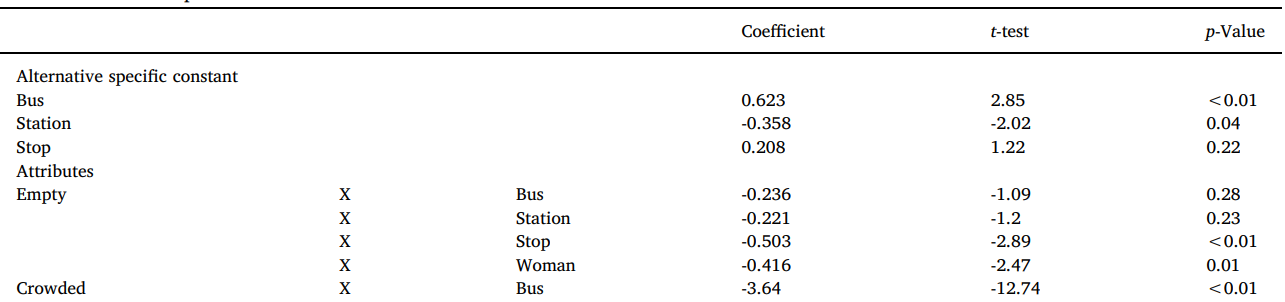

Seperti yang terlihat pada tabel di atas, kepadatan penumpang yang tinggi memiliki potensi risiko yang lebih besar, yang memerlukan perhatian lebih dalam penempatan armada bus pink. Koridor dengan tingkat kepadatan tinggi, terutama pada jam sibuk, dapat meningkatkan risiko pelecehan atau ketidaknyamanan bagi penumpang wanita. [Sumber Table 5]('https://www.sciencedirect.com/science/article/abs/pii/S2214140519301525')

Pada tahap ini, kita akan menghitung jumlah penumpang pria dan wanita pada setiap rute **TransJakarta**. Proses dimulai dengan mengelompokkan data berdasarkan **rute** (**`corridorName`**) dan **jenis kelamin penumpang** (**`payCardSex`**). Selanjutnya, kita akan menghitung jumlah penumpang pria dan wanita pada setiap rute, serta menghitung persentase masing-masing jenis kelamin. Setelah itu, kepadatan penumpang akan dihitung dengan membagi **total jumlah penumpang** dengan **jumlah keberangkatan**.


In [135]:
gender_route = df_clean.groupby(['corridorID', 'payCardSex']).size().reset_index(name='count')
keberangkatan_dict = {entry['corridorId']: entry['totalKebarangkatan'] for entry in jadwalKeberangkatan}

pivot_data = gender_route.pivot(index='corridorID', columns='payCardSex', values='count').fillna(0)
pivot_data['Total'] = pivot_data.sum(axis=1)
pivot_data['Jumlah Keberangkatan'] = pivot_data.index.map(keberangkatan_dict)
pivot_data['Kepadatan'] = pivot_data['Total'] / pivot_data['Jumlah Keberangkatan']
pivot_data['Pria (%)'] = (pivot_data['M'] / pivot_data['Total']) * 100
pivot_data['Wanita (%)'] = (pivot_data['F'] / pivot_data['Total']) * 100

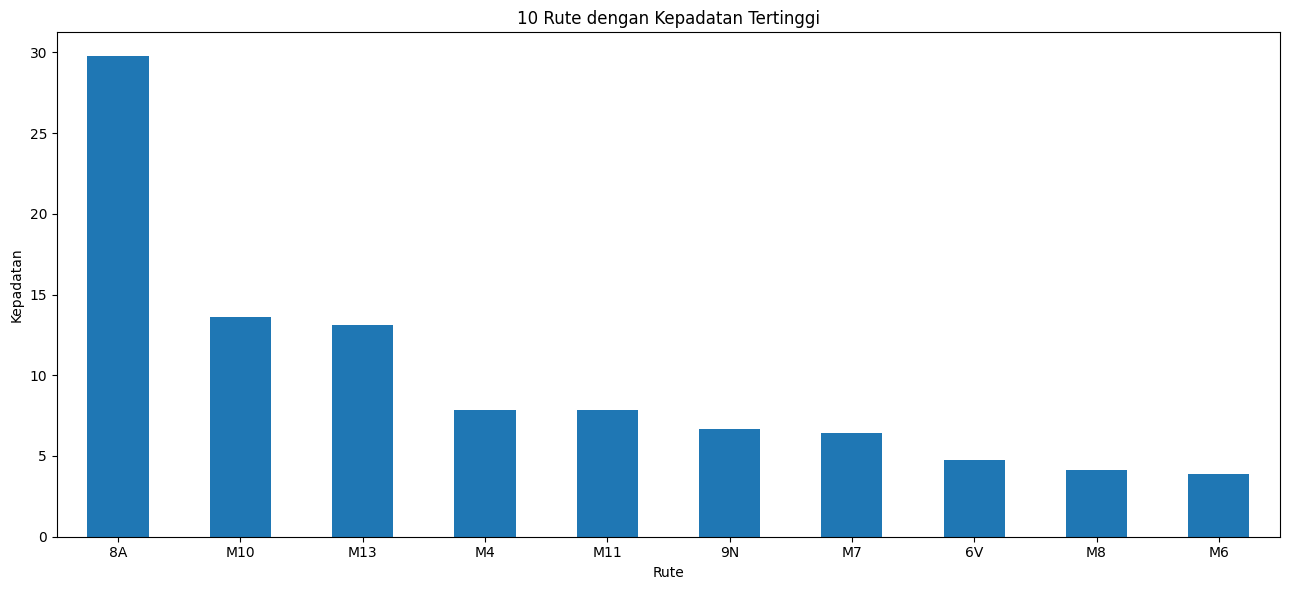

In [146]:
rute_terpadat = pivot_data.sort_values(by='Kepadatan', ascending=False).head(10)

ax = rute_terpadat[['Kepadatan']].plot(kind='bar', figsize=(13, 6))
plt.xlabel('Rute')
plt.ylabel('Kepadatan')
plt.title('10 Rute dengan Kepadatan Tertinggi')
plt.xticks(rotation=0)
plt.tight_layout()
ax.get_legend().remove()
plt.show()

Koridor 8A tercatat sebagai koridor dengan kepadatan penumpang tertinggi, menandakan bahwa rute ini memiliki volume penumpang yang sangat besar.

## Menganalisis Proporsi Penumpang Wanita Usia 18-35 Tahun

Setelah menentukan kepadatan penumpang, langkah berikutnya adalah menganalisis proporsi penumpang wanita berusia 18-35 tahun di setiap koridor. Kelompok usia ini dianggap rentan terhadap masalah keamanan di transportasi umum, termasuk pelecehan seksual. Oleh karena itu, penting untuk mengetahui apakah penempatan armada bus pink sudah sesuai dengan koridor yang memiliki jumlah penumpang wanita di rentang usia ini yang lebih tinggi.

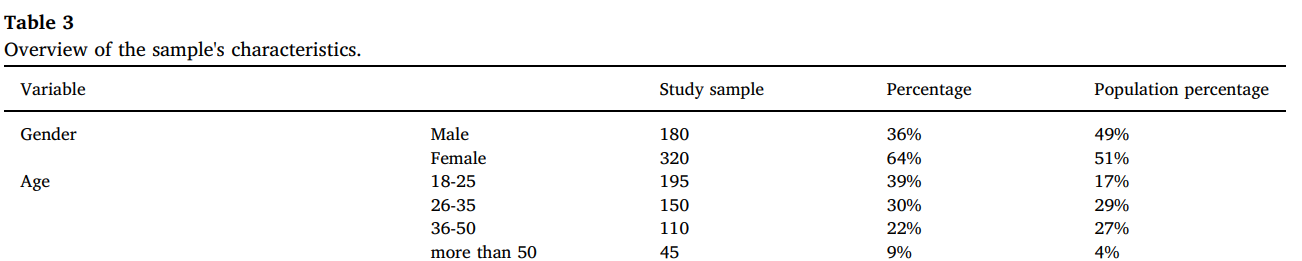

Seperti yang terlihat pada tabel di atas, **proporsi penumpang wanita usia 18-35 tahun yang lebih tinggi** memiliki potensi risiko yang lebih besar, yang memerlukan perhatian lebih dalam penempatan armada bus pink. Koridor dengan proporsi wanita usia 18-35 tahun yang besar dapat meningkatkan risiko pelecehan atau ketidaknyamanan bagi penumpang wanita, mengingat kelompok usia ini lebih rentan terhadap masalah keamanan di transportasi umum. [Sumber Table 3]('https://www.sciencedirect.com/science/article/abs/pii/S2214140519301525')

Sebelum melakukan analisa kita akan menambahkan kolom age dan age category, yang berisi umur dan kategori dia lebih dari 35 atau tidak, dan kita tidak menggunakan data yang usianya di bawah 18 tahun karena itu cukup sensitif jika dibahas

In [133]:
df_clean['age'] = 2023 - df['payCardBirthDate']
df_clean = df_clean[df_clean['age'] >= 18]
df_clean['ageCategory']= np.where(df_clean['age'] <= 35, '<= 35', '> 35')
df_clean

,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,...,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,age,ageCategory
4,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,Keberangkatan,P00239,Sunter Boulevard Barat,...,2023-04-03 06:17:35,P00098,Kali Besar Barat,-6.135355,106.81143,15.0,2023-04-03 06:57:03,3500.0,41,> 35
12,3536759468239783,dki,Shakila Maryadi,F,1988,9A,PGC 2 - Grogol 2,Pulang,P00281,Slipi Petamburan Arah Selatan,...,2023-04-03 06:15:04,P00216,Semanggi,-6.221110,106.81354,6.0,2023-04-03 07:08:31,3500.0,35,<= 35
13,6575130739600630,dki,Danuja Usada,F,2002,4,Pulo Gadung 2 - Tosari,Pulang,P00159,Pasar Rumput,...,2023-04-03 06:12:14,P00135,Matraman 2,-6.198910,106.85450,4.0,2023-04-03 07:07:35,3500.0,21,<= 35
16,4556326832434362836,brizzi,Sari Nababan,F,2004,13,Ciledug - Tendean,Pulang,P00096,JORR,...,2023-04-03 06:49:48,P00001,Adam Malik,-6.236466,106.74786,11.0,2023-04-03 07:47:42,3500.0,19,<= 35
18,502034641014,flazz,"Adikara Kurniawan, S.Sos",M,2003,9,Pinang Ranti - Pluit,Pulang,P00093,Jembatan Tiga Arah Utara,...,2023-04-03 06:24:23,P00145,Pancoran Tugu Arah Barat,-6.243300,106.84388,16.0,2023-04-03 07:07:12,3500.0,20,<= 35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37883,581570008267,flazz,"Genta Utama, S.E.I",M,1986,3,Kalideres - Bundaran HI via Veteran,Pulang,P00176,Petojo,...,2023-04-19 15:14:24,P00025,Bundaran HI,-6.193021,106.82300,16.0,2023-04-19 17:58:41,3500.0,37,> 35
37887,4068989702474318,dki,Ajimat Pradana,F,1980,4D,Pulo Gadung 2 - Kuningan,Keberangkatan,P00269,Velodrome,...,2023-04-04 14:52:31,P00189,Pramuka LIA,-6.192238,106.86858,9.0,2023-04-04 15:38:58,3500.0,43,> 35
37895,4685818286724028395,brizzi,Kamila Mahendra,F,2004,6B,Ragunan - MH Thamrin via Semanggi,Pulang,P00261,Tosari,...,2023-04-21 18:18:37,P00228,SMK 57,-6.290967,106.82365,13.0,2023-04-21 19:55:49,3500.0,19,<= 35
37896,6502902290603767,dki,Titi Siregar,M,1974,9N,Pinang Ranti - Pramuka,Pulang,P00064,Garuda Taman Mini,...,2023-04-18 21:52:31,P00179,Pinang Ranti,-6.291075,106.88634,2.0,2023-04-18 22:28:22,3500.0,49,> 35


Setelah menambahkan, kita akan menghitung jumlah penumpang pria dan wanita pada setiap rute **TransJakarta**. Proses dimulai dengan mengelompokkan data berdasarkan **rute** (**`corridorName`**) dan **jenis kelamin penumpang** (**`payCardSex`**). Selanjutnya, kita akan menghitung jumlah penumpang pria dan wanita pada setiap rute, serta mengkolompokan bedasarkan usia dan menghitung persentase masing-masing jenis kelamin.

In [147]:
age_route = df_clean.groupby(['corridorID', 'ageCategory', 'payCardSex']).size().reset_index(name='count')
age_route['ageSexCategory'] = age_route['ageCategory'] + ' ' + age_route['payCardSex']

pivot_data_age = age_route.pivot_table(index='corridorID', columns='ageSexCategory', values='count', aggfunc='sum', fill_value=0)

pivot_data_age['Total'] = pivot_data_age.sum(axis=1)

for category in pivot_data_age.columns:
    if category != 'Total':
        pivot_data_age[category + ' (%)'] = (pivot_data_age[category] / pivot_data_age['Total']) * 100

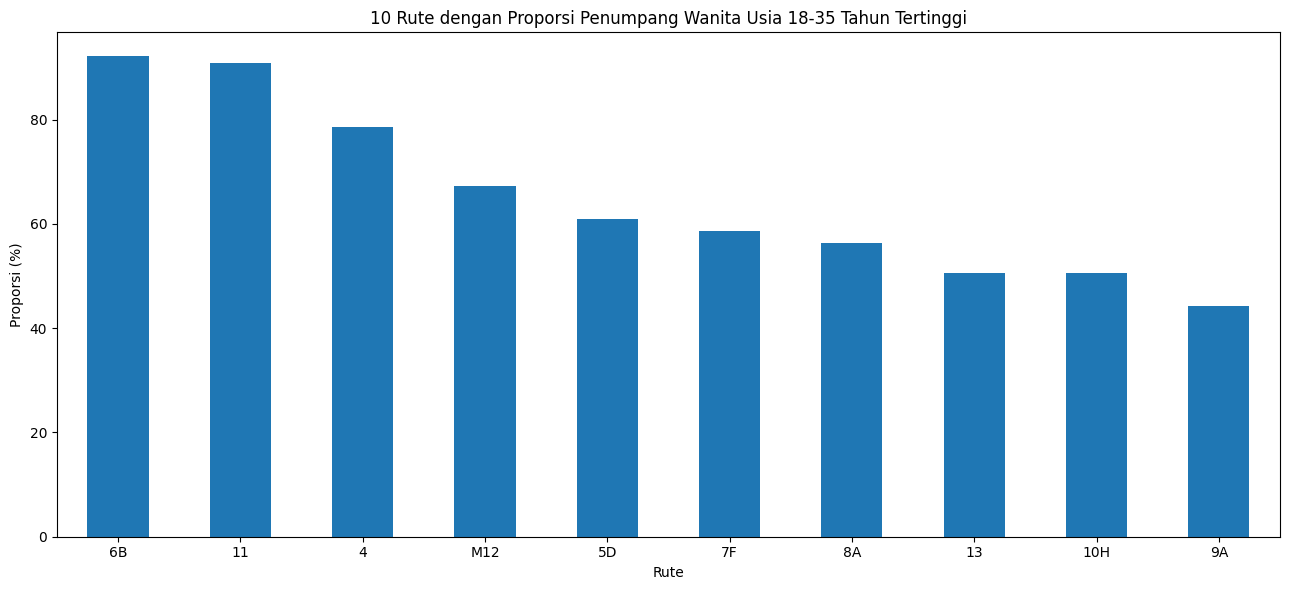

In [144]:
rute_dengan_wanita_dibawah_35_terbanyak = pivot_data_age.sort_values(by='<= 35 F (%)', ascending=False).head(10)

ax = rute_dengan_wanita_dibawah_35_terbanyak[['<= 35 F (%)']].plot(kind='bar', figsize=(13, 6))
plt.xlabel('Rute')
plt.ylabel('Proporsi (%)')
plt.title('10 Rute dengan Proporsi Penumpang Wanita Usia 18-35 Tahun Tertinggi')
plt.xticks(rotation=0)
plt.tight_layout()
ax.get_legend().remove()
plt.show()

## Mengecek Kesesuaian Penempatan Armada Bus Pink di Lima Koridor

 Pada step ini, kita akan melakukan evaluasi untuk memastikan apakah penempatan armada bus pink di lima koridor TransJakarta yang telah ditentukan sudah sesuai dan tepat.

Langkah-langkah yang akan diambil dalam tahap ini adalah sebagai berikut:

1. **Analisis **Kepadatan Penumpang****: Kita akan mengidentifikasi lima koridor yang saat ini menggunakan armada bus pink dan mengukur kepadatan penumpang di setiap koridor. Hal ini akan mencakup analisis terhadap jumlah total penumpang dan perbandingannya dengan jumlah keberangkatan (sebagai indikator kepadatan).

2. **Identifikasi Proporsi Penumpang Wanita Usia 18-35 Tahun**: Kita akan menganalisis data penumpang berdasarkan jenis kelamin dan kelompok usia untuk setiap koridor yang menggunakan bus pink. Fokus utama adalah proporsi penumpang wanita usia 18-35 tahun yang melebihi 50% pada koridor-koridor tersebut.

Tujuan dari langkah ini adalah untuk memastikan bahwa armada bus pink telah ditempatkan pada koridor yang membutuhkan dan siap melayani kebutuhan penumpang dengan optimal.


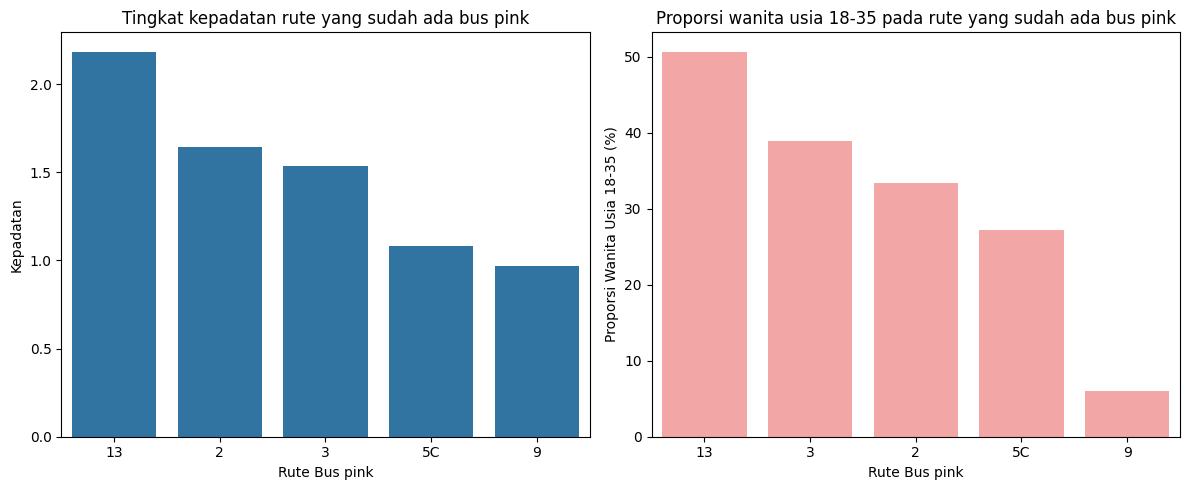

In [219]:
corridorIdBusPink = ['2','3','9','13','5C']
df_merged = pd.merge(pivot_data_age.reset_index(), pivot_data.reset_index())
df_bus_pink = df_merged[df_merged['corridorID'].isin(corridorIdBusPink)]
df_bus_pink_sorted_by_kepadatan = df_bus_pink.sort_values(by='Kepadatan', ascending=False)

df_bus_pink_sorted_by_proporsi = df_bus_pink.sort_values(by='<= 35 F (%)', ascending=False)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.barplot(data=df_bus_pink_sorted_by_kepadatan, x='corridorID', y='Kepadatan')
plt.ylabel('Kepadatan')
plt.xlabel('Rute Bus pink')
plt.title('Tingkat kepadatan rute yang sudah ada bus pink')

plt.subplot(1, 2, 2)
sns.barplot(data=df_bus_pink_sorted_by_proporsi, x='corridorID', y='<= 35 F (%)', color='#ff9999')
plt.ylabel('Proporsi Wanita Usia 18-35 (%)')
plt.xlabel('Rute Bus pink')

plt.title('Proporsi wanita usia 18-35 pada rute yang sudah ada bus pink')
plt.tight_layout()
plt.show()


Dari grafik di atas, terlihat bahwa penempatan rute **Bus Pink** pada beberapa koridor kurang optimal jika dilihat berdasarkan dua indikator utama, yaitu **kepadatan penumpang** dan **proporsi penumpang wanita usia 18-35 tahun**.

1. **Kepadatan Penumpang** 

    Kepadatan penumpang pada rute-rute yang telah dilayani oleh **Bus Pink** (13, 2, 3, 5C, dan 9) terlihat masih berada di bawah nilai median. Hal ini menunjukkan bahwa rute-rute ini belum mencerminkan kebutuhan layanan berdasarkan jumlah penumpang yang tinggi. Kondisi ini menjadi perhatian karena salah satu tujuan utama dari pengadaan **Bus Pink** adalah memberikan pelayanan yang efisien dan memadai pada rute dengan permintaan tinggi.

2. **Proporsi Penumpang Wanita Usia 18-35 Tahun**

    Indikator kedua menunjukkan bahwa proporsi penumpang wanita usia 18-35 tahun pada rute-rute tersebut sebagian besar berada di bawah angka **55%**. Hal ini kurang sejalan dengan tujuan utama **Bus Pink**, yang dirancang untuk melayani penumpang wanita, terutama pada kelompok usia yang lebih rentan terhadap risiko pelecehan atau ketidaknyamanan.



## Mengidentifikasi Koridor Lain yang Membutuhkan Armada Bus Pink


Setelah mengevaluasi apakah penempatan armada bus pink di lima koridor yang ada sudah tepat, kita akan mengidentifikasi **koridor lain** yang mungkin juga membutuhkan armada bus pink. Analisis ini akan berfokus pada dua kriteria utama: **kepadatan penumpang di atas median** dan **proporsi wanita usia 18-35 tahun di atas 55%**.

Langkah-langkah yang akan diambil dalam tahap ini adalah sebagai berikut:

1. **Kepadatan Penumpang di atas Median**:
   - Kita akan menggunakan **median kepadatan** penumpang untuk mengidentifikasi koridor-koridor dengan kepadatan yang lebih tinggi dari nilai median tersebut. Koridor dengan kepadatan di atas median menunjukkan bahwa jumlah penumpang yang menggunakan rute tersebut relatif lebih tinggi, dan dengan demikian, kebutuhan untuk armada yang lebih banyak dan terfokus juga akan lebih besar.
   - **Tujuan**: Menentukan koridor yang lebih padat, sehingga dapat dipastikan bahwa penempatan armada bus pink bisa lebih efisien dan tepat sasaran.

2. **Proporsi Wanita Usia 18-35 Tahun di atas 55%**:
   - Koridor dengan proporsi penumpang wanita usia 18-35 tahun di atas **55%** dianggap memiliki potensi risiko tinggi terkait pelecehan seksual. Penempatan armada bus pink di koridor ini bertujuan untuk memastikan rasa aman bagi penumpang wanita, terutama yang berada dalam kelompok usia rentan tersebut.
   - **Tujuan**: Memastikan armada bus pink melayani koridor dengan konsentrasi penumpang wanita yang tinggi untuk mengurangi potensi risiko pelecehan seksual dan memberikan rasa aman pada perjalanan mereka.

3. **Efisiensi Penggunaan Armada dan Penghematan Sumber Daya**:
   - Dengan menggunakan dua kriteria ini—**kepadatan di atas median** dan **proporsi wanita usia 18-35 tahun lebih dari 55%**—kita dapat fokus pada koridor yang memiliki kebutuhan armada bus pink yang lebih besar. Hal ini memungkinkan penempatan armada secara lebih selektif dan efisien, sehingga sumber daya seperti armada bus dan tenaga kerja dapat digunakan dengan lebih optimal.
   - **Tujuan**: Menghemat sumber daya dengan menempatkan armada bus pink hanya pada koridor yang benar-benar membutuhkan, menghindari pemborosan armada pada rute yang tidak memiliki tingkat kepadatan tinggi atau proporsi penumpang wanita yang signifikan.

4. **Rekomendasi Penempatan Armada**:
   - Berdasarkan analisis ini, kita akan mengusulkan penempatan tambahan armada bus pink pada koridor-koridor yang memiliki **kepadatan penumpang tinggi** dan **proporsi penumpang wanita usia 18-35 tahun** yang signifikan, guna meningkatkan efisiensi pelayanan dan mengurangi potensi risiko pelecehan seksual.

Tujuan dari langkah ini adalah untuk memastikan armada bus pink ditempatkan pada koridor yang benar-benar membutuhkan, dengan mempertimbangkan kepadatan penumpang dan proporsi wanita usia 18-35 tahun yang tinggi. Dengan demikian, kita tidak hanya meningkatkan keamanan bagi penumpang wanita, tetapi juga mengoptimalkan penggunaan sumber daya armada bus untuk efisiensi yang lebih baik.

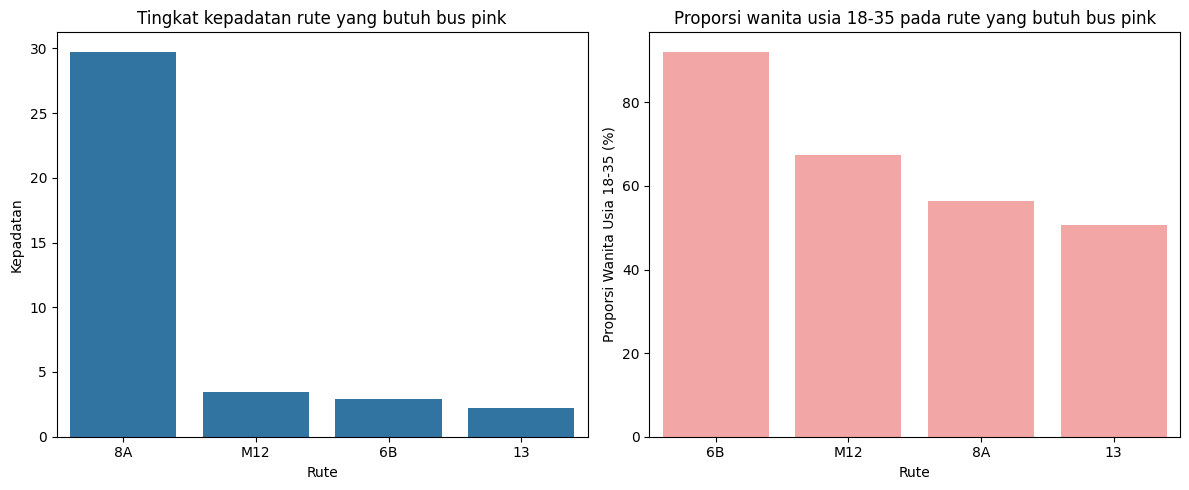

In [214]:
butuh_bus_pink  = df_merged[(df_merged['<= 35 F (%)'] > 50) & (df_merged['Wanita (%)'] > 50)].sort_values('Kepadatan', ascending=False)
butuh_bus_pink = butuh_bus_pink[butuh_bus_pink['Kepadatan'] > df_merged['Kepadatan'].median()]
butuh_bus_pink_sorted_by_kepadatan = butuh_bus_pink.sort_values(by='Kepadatan', ascending=False)

butuh_bus_pink_sorted_by_proporsi = butuh_bus_pink.sort_values(by='<= 35 F (%)', ascending=False)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.barplot(data=butuh_bus_pink_sorted_by_kepadatan, x='corridorID', y='Kepadatan')
plt.ylabel('Kepadatan')
plt.xlabel('Rute')
plt.title('Tingkat kepadatan rute yang butuh bus pink')

plt.subplot(1, 2, 2)
sns.barplot(data=butuh_bus_pink_sorted_by_proporsi, x='corridorID', y='<= 35 F (%)', color='#ff9999')
plt.ylabel('Proporsi Wanita Usia 18-35 (%)')
plt.xlabel('Rute')

plt.title('Proporsi wanita usia 18-35 pada rute yang butuh bus pink')
plt.tight_layout()
plt.show()

Dari grafik di atas, beberapa koridor menunjukkan kebutuhan penempatan Bus Pink yang lebih tinggi:

1. Koridor M12 dengan proporsi wanita 67,31% dan kepadatan 3,47, serta Koridor 8A dengan proporsi wanita 56,30% dan kepadatan 29,75, yang menunjukkan kebutuhan layanan Bus Pink yang sangat tinggi.
1. Koridor 6B memiliki proporsi wanita 92,13% dan kepadatan 2,89, juga memerlukan perhatian untuk penambahan armada Bus Pink.

1. Koridor 13 memiliki proporsi wanita 50,67% dan kepadatan 2,18, yang meskipun sedikit lebih rendah, tetap perlu dipertimbangkan untuk meningkatkan pelayanan Bus Pink.

Dengan analisis ini, saya bertujuan untuk memberikan gambaran yang jelas dan berbasis data tentang rute-rute yang paling membutuhkan prioritas dalam penambahan armada bus pink khusus untuk wanita, guna menciptakan lingkungan yang lebih aman dan nyaman bagi penumpang wanita di TransJakarta.

# **Kesimpulan dan Rekomendasi**

Berdasarkan analisis, penempatan armada bus pink di lima koridor utama belum optimal. Beberapa koridor dengan **kepadatan tinggi** dan **proporsi wanita besar** membutuhkan perhatian lebih. Rekomendasi berikutnya adalah **penyesuaian penempatan armada** untuk meningkatkan **keamanan dan efisiensi**.


---

Berdasarkan analisis data **kepadatan penumpang** dan **proporsi wanita usia 18-35 tahun**, dapat disimpulkan bahwa penempatan armada **bus pink** di lima koridor utama (**Koridor 2, 3, 9, 13, dan 5C**) belum sepenuhnya optimal. Beberapa temuan utama adalah sebagai berikut:

1.  **Koridor yang Dilayani Bus Pink**:  
    Pada koridor-koridor yang saat ini dilayani **Bus Pink**, sebagian besar masih menunjukkan kepadatan penumpang yang relatif rendah dibandingkan dengan **nilai median**. Hal ini menunjukkan bahwa penempatan armada **bus pink** tidak sepenuhnya sesuai dengan kebutuhan penumpang, terutama untuk koridor yang memiliki permintaan tinggi.

2.  **Koridor dengan Proporsi Penumpang Wanita yang Tinggi**:  
    Beberapa koridor lainnya, seperti **Koridor 6B** (proporsi wanita **92,13%**) dan **M12** (proporsi wanita **67,31%**), menunjukkan konsentrasi penumpang wanita yang jauh lebih tinggi dibandingkan dengan koridor yang sudah dilayani **Bus Pink**. Koridor-koridor ini lebih membutuhkan penempatan **Bus Pink** untuk memberikan rasa aman dan nyaman, khususnya bagi penumpang wanita yang berisiko terhadap potensi pelecehan seksual.

3.  **Kepadatan yang Tinggi pada Beberapa Koridor Lain**:  
    Koridor seperti **8A** dan **13** menunjukkan kepadatan penumpang yang relatif tinggi dan proporsi wanita yang cukup signifikan, sehingga penempatan armada **Bus Pink** di koridor-koridor ini juga perlu dipertimbangkan untuk meningkatkan kenyamanan dan mengurangi risiko ketidaknyamanan bagi penumpang wanita.

## Rekomendasi

1.  **Evaluasi Ulang Penempatan Armada Bus Pink di Lima Koridor Utama**:  
    Penempatan **Bus Pink** di lima koridor utama (**Koridor 2, 3, 9, 13, dan 5C**) perlu dievaluasi lebih lanjut, terutama untuk koridor yang memiliki kepadatan penumpang rendah. **Bus Pink** sebaiknya diprioritaskan pada koridor dengan kepadatan penumpang lebih tinggi dan proporsi wanita yang signifikan, untuk memastikan armada digunakan secara efisien.

2.  **Penambahan Armada Bus Pink pada Koridor dengan Proporsi Wanita Tinggi**:  
    Berdasarkan hasil analisis, koridor seperti **6B**, **M12**, dan **8A** menunjukkan **proporsi wanita yang tinggi** dan **kepadatan penumpang** yang cukup signifikan. Penempatan tambahan armada **Bus Pink** di koridor-koridor ini akan meningkatkan keamanan dan kenyamanan penumpang wanita, terutama di rute-rute yang memiliki konsentrasi wanita usia 18-35 tahun lebih dari 50%.
    
3.  **Peningkatan Kepadatan dan Efisiensi Penggunaan Armada**:  
    Sebagai langkah lanjutan, penempatan armada **Bus Pink** harus berbasis pada **data kepadatan penumpang** dan **proporsi wanita usia 18-35 tahun**. Dengan demikian, armada dapat digunakan lebih efisien, hanya pada koridor yang benar-benar membutuhkan, untuk menghindari pemborosan sumber daya dan memastikan layanan yang lebih optimal.
    
4.  **Pemantauan dan Penyesuaian Secara Berkala**:  
    Mengingat perubahan pola penumpang dari waktu ke waktu, pemantauan dan evaluasi secara berkala terhadap kepadatan penumpang dan proporsi wanita di setiap koridor sangat diperlukan. Hal ini akan memastikan bahwa armada **Bus Pink** selalu ditempatkan di lokasi yang paling membutuhkan dan efektif dalam memberikan rasa aman bagi penumpang wanita.